<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1095 non-null   datetime64[ns]
 1   PM2.5   1095 non-null   float64       
 2   PM10    1095 non-null   float64       
 3   NO      1095 non-null   float64       
 4   NO2     1095 non-null   float64       
 5   NOx     1095 non-null   float64       
 6   SO2     1095 non-null   float64       
 7   CO      1095 non-null   float64       
 8   Ozone   1095 non-null   float64       
 9   WS      1095 non-null   float64       
 10  WD      1095 non-null   float64       
 11  SR      1095 non-null   float64       
 12  RH      1095 non-null   float64       
 13  TEMP    1095 non-null   float64       
 14  Year    1095 non-null   int32         
dtypes: datetime64[ns](1), float64(13), int32(1)
memory usage: 124.2 KB
None
                      Date        PM2.5         PM10           NO  \

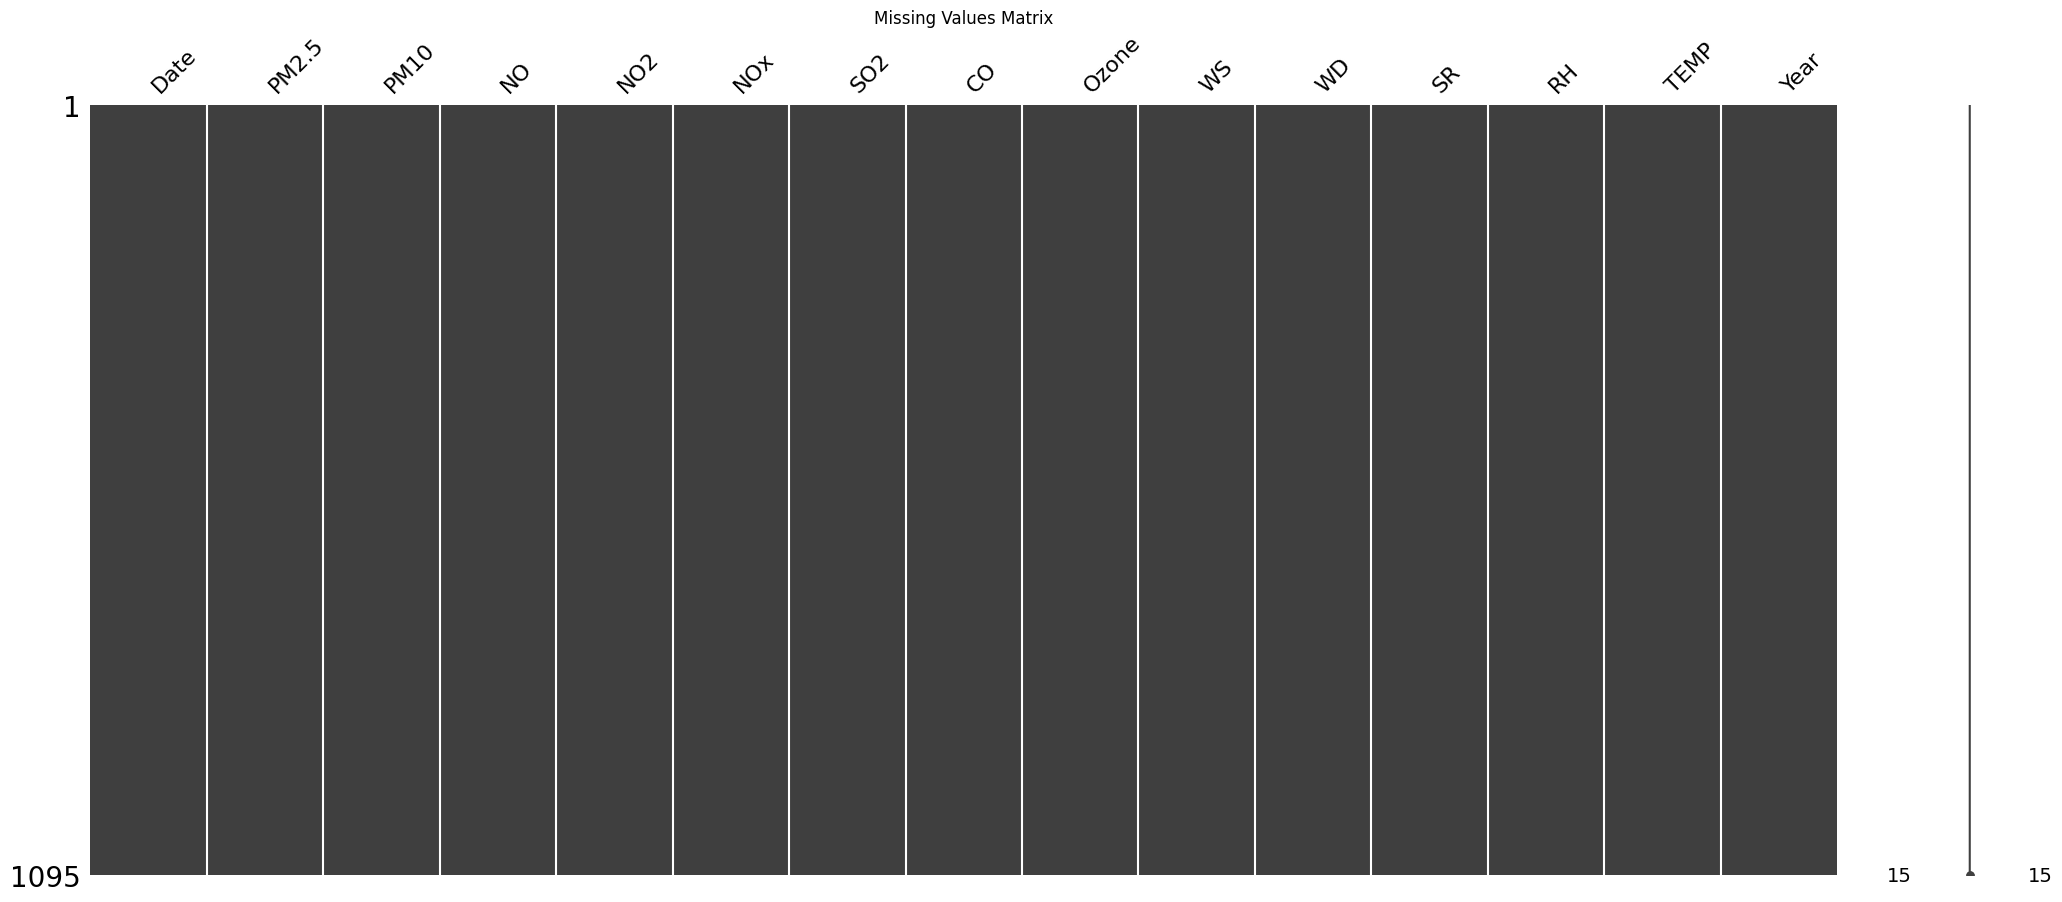

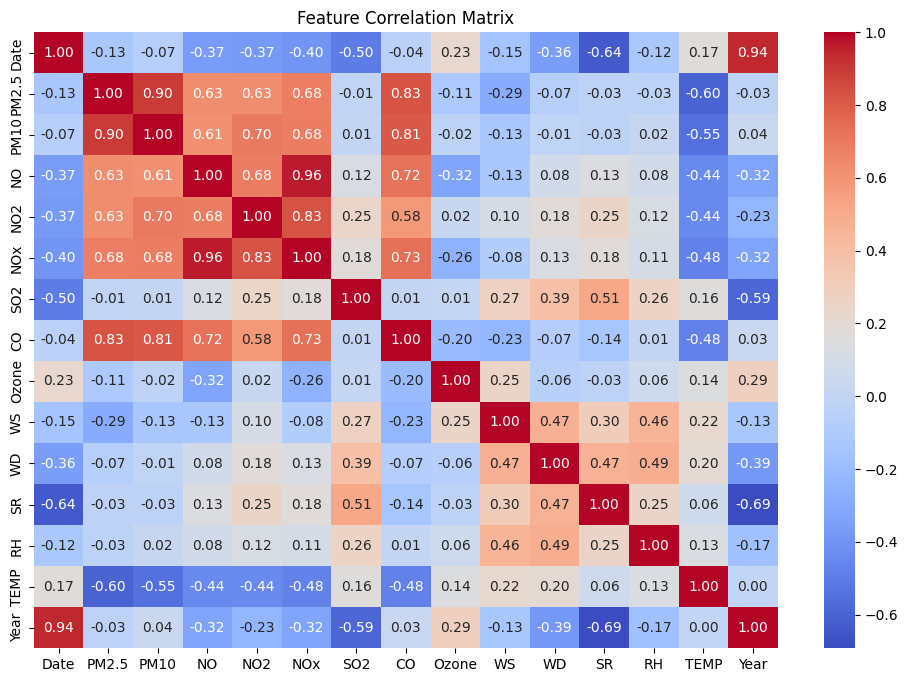

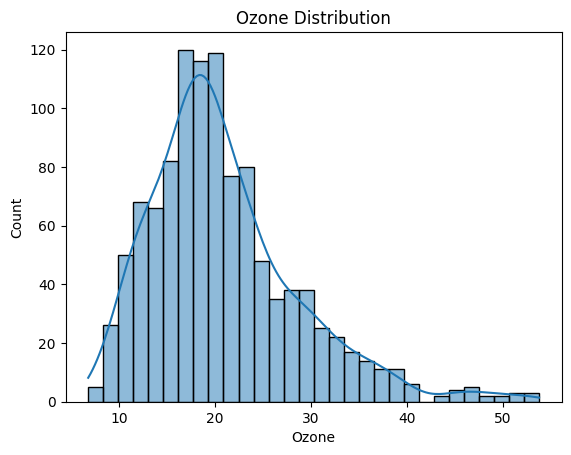

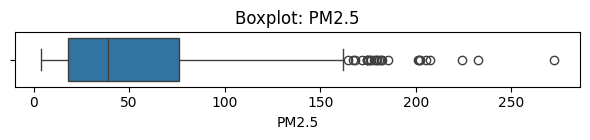

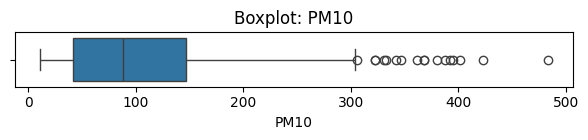

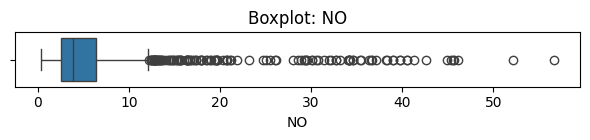

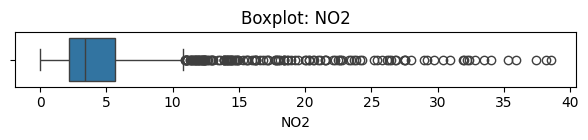

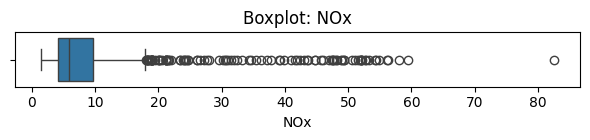

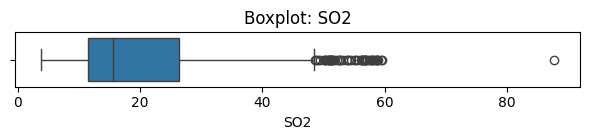

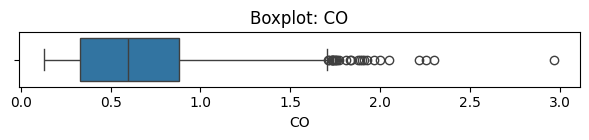

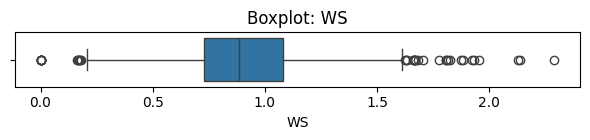

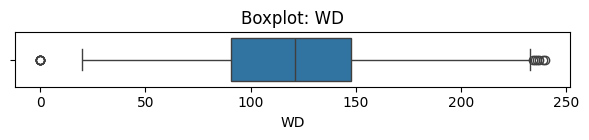

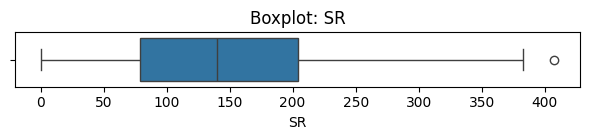

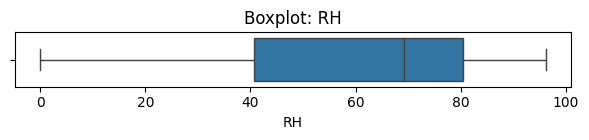

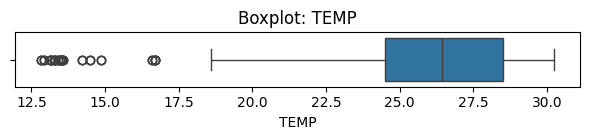

Running Ridge | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running Decision Tree | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running Random Forest | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running SVM | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running KNN | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running Gradient Boosting | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running XGBoost | 1Y (2023) | Emission | Split: 80:20 | With Outliers
Running Ridge | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running Decision Tree | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running Random Forest | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running SVM | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running KNN | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running Gradient Boosting | 1Y (2023) | Emission | Split: 80:20 | Outliers Removed
Running XGBoost | 1Y (2023) | Emission | Split: 

In [5]:
# Ozone Level Regression: Full Experimental Pipeline (With EDA and Outlier Variation)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Define model and parameters
# -------------------------
models = {
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'KNN': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(verbosity=0)
}

param_grids = {
    'Ridge': {'alpha': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'Random Forest': {'n_estimators': [100], 'max_depth': [10, 20], 'max_features': ['sqrt', None]},
    'SVM': {'C': [1], 'epsilon': [0.1], 'kernel': ['rbf'], 'gamma': ['scale']},
    'KNN': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    'Gradient Boosting': {'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'XGBoost': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3, 5], 'subsample': [1.0]}
}

# -------------------------
# Load Dataset
# -------------------------
df_full = pd.read_excel('data_for OZONE_prediction.xlsx')
df_full['Year'] = df_full['Date'].dt.year

# -------------------------
# EDA
# -------------------------
print(df_full.info())
print(df_full.describe())

msno.matrix(df_full)
plt.title("Missing Values Matrix")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_full.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

sns.histplot(df_full['Ozone'], kde=True, bins=30)
plt.title("Ozone Distribution")
plt.xlabel("Ozone")
plt.show()

for col in df_full.columns:
    if col not in ['Date', 'Year', 'Ozone']:
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df_full[col])
        plt.title(f"Boxplot: {col}")
        plt.tight_layout()
        plt.show()

# -------------------------
# Define Feature Sets and Time Windows
# -------------------------
feature_sets = {
    "Emission": ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'SO2', 'CO'],
    "Meteorological": ['WS', 'WD', 'SR', 'RH', 'TEMP'],
    "Combined": ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'SO2', 'CO', 'WS', 'WD', 'SR', 'RH', 'TEMP']
}

time_windows = {
    '1Y (2023)': df_full[df_full['Year'] == 2023],
    '2Y (2022-2023)': df_full[df_full['Year'].isin([2022, 2023])],
    '3Y (2021-2023)': df_full
}

# -------------------------
# Outlier Removal Function (IQR method)
# -------------------------
def remove_outliers_iqr(df, features):
    df_clean = df.copy()
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR)))
        if outliers.sum() / len(df_clean) < 0.10:
            df_clean = df_clean[~outliers]
    return df_clean

# -------------------------
# Begin Experiments
# -------------------------
all_results = []
split_ratios = [(0.8, '80:20'), (0.7, '70:30')]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for time_label, df_t in time_windows.items():
    for feat_label, features in feature_sets.items():
        for split_val, split_label in split_ratios:
            for outlier_flag in [False, True]:
                df_variant = remove_outliers_iqr(df_t, features) if outlier_flag else df_t.copy()
                out_label = "Outliers Removed" if outlier_flag else "With Outliers"

                X = df_variant[features]
                y = df_variant['Ozone']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - split_val, random_state=42)

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                for name, model in models.items():
                    print(f"Running {name} | {time_label} | {feat_label} | Split: {split_label} | {out_label}")
                    param_grid = param_grids[name]
                    use_scaled = name in ['SVM', 'KNN']

                    grid = GridSearchCV(model, param_grid, scoring='r2', cv=cv, n_jobs=-1)
                    if use_scaled:
                        grid.fit(X_train_scaled, y_train)
                        y_pred = grid.predict(X_test_scaled)
                    else:
                        grid.fit(X_train, y_train)
                        y_pred = grid.predict(X_test)

                    all_results.append({
                        'Time Window': time_label,
                        'Feature Set': feat_label,
                        'Split': split_label,
                        'Outlier Handling': out_label,
                        'Model': name,
                        'MAE': mean_absolute_error(y_test, y_pred),
                        'MSE': mean_squared_error(y_test, y_pred),
                        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                        'R2': r2_score(y_test, y_pred),
                        'Best Params': grid.best_params_
                    })

# -------------------------
# Create Results DataFrame
# -------------------------
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values(by='R2', ascending=False)





In [6]:
results_df_sorted.head(20)

,Time Window,Feature Set,Split,Outlier Handling,Model,MAE,MSE,RMSE,R2,Best Params
74,1Y (2023),Combined,70:30,With Outliers,KNN,2.557590,14.107246,3.755961,0.814960,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
60,1Y (2023),Combined,80:20,With Outliers,KNN,2.627356,13.877684,3.725276,0.813025,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
144,2Y (2022-2023),Combined,80:20,With Outliers,KNN,2.846488,14.049946,3.748326,0.800766,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
68,1Y (2023),Combined,80:20,Outliers Removed,Gradient Boosting,2.956268,16.874993,4.107918,0.780003,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
69,1Y (2023),Combined,80:20,Outliers Removed,XGBoost,2.790504,16.926492,4.114182,0.779331,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
32,1Y (2023),Meteorological,80:20,With Outliers,KNN,2.827449,16.618460,4.076575,0.776099,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
81,1Y (2023),Combined,70:30,Outliers Removed,KNN,2.864832,18.346080,4.283232,0.761356,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
18,1Y (2023),Emission,70:30,With Outliers,KNN,2.816353,18.512130,4.302572,0.757183,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
159,2Y (2022-2023),Combined,70:30,With Outliers,Gradient Boosting,2.922874,14.977322,3.870054,0.754107,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
72,1Y (2023),Combined,70:30,With Outliers,Random Forest,2.998919,18.787109,4.334410,0.753576,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e..."



========== Results for 1Y (2023) ==========

Top 15 Models by R²:


,Feature Set,Split,Outlier Handling,Model,R2,RMSE,MAE
74,Combined,70:30,With Outliers,KNN,0.814960,3.755961,2.557590
60,Combined,80:20,With Outliers,KNN,0.813025,3.725276,2.627356
68,Combined,80:20,Outliers Removed,Gradient Boosting,0.780003,4.107918,2.956268
69,Combined,80:20,Outliers Removed,XGBoost,0.779331,4.114182,2.790504
32,Meteorological,80:20,With Outliers,KNN,0.776099,4.076575,2.827449
81,Combined,70:30,Outliers Removed,KNN,0.761356,4.283232,2.864832
18,Emission,70:30,With Outliers,KNN,0.757183,4.302572,2.816353
72,Combined,70:30,With Outliers,Random Forest,0.753576,4.334410,2.998919
75,Combined,70:30,With Outliers,Gradient Boosting,0.748344,4.380182,3.070759
65,Combined,80:20,Outliers Removed,Random Forest,0.733811,4.518647,3.031097


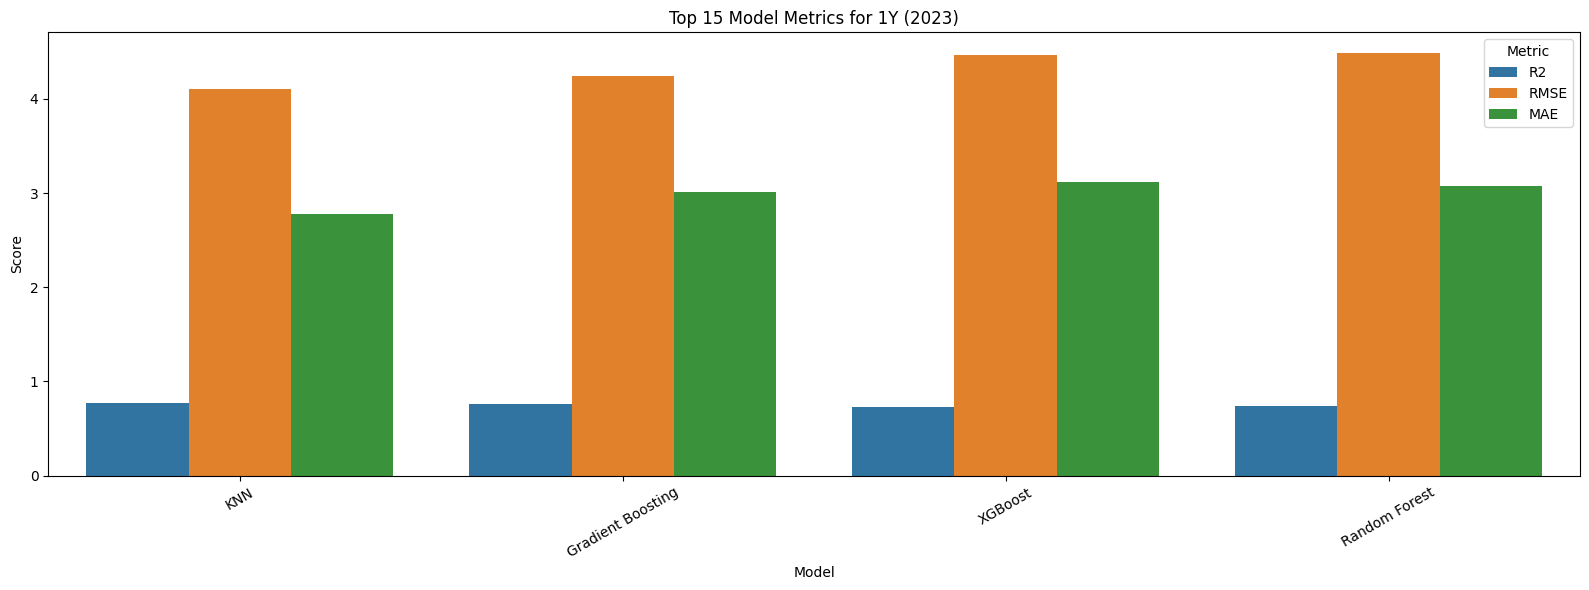


========== Results for 2Y (2022-2023) ==========

Top 15 Models by R²:


,Feature Set,Split,Outlier Handling,Model,R2,RMSE,MAE
144,Combined,80:20,With Outliers,KNN,0.800766,3.748326,2.846488
159,Combined,70:30,With Outliers,Gradient Boosting,0.754107,3.870054,2.922874
142,Combined,80:20,With Outliers,Random Forest,0.753442,4.169803,3.164368
146,Combined,80:20,With Outliers,XGBoost,0.748449,4.211815,3.340814
145,Combined,80:20,With Outliers,Gradient Boosting,0.747433,4.220308,3.291802
160,Combined,70:30,With Outliers,XGBoost,0.742373,3.961316,3.100502
156,Combined,70:30,With Outliers,Random Forest,0.723932,4.100639,3.164216
88,Emission,80:20,With Outliers,KNN,0.713250,4.496839,3.324771
158,Combined,70:30,With Outliers,KNN,0.704374,4.243409,3.024353
86,Emission,80:20,With Outliers,Random Forest,0.700012,4.599470,3.471569


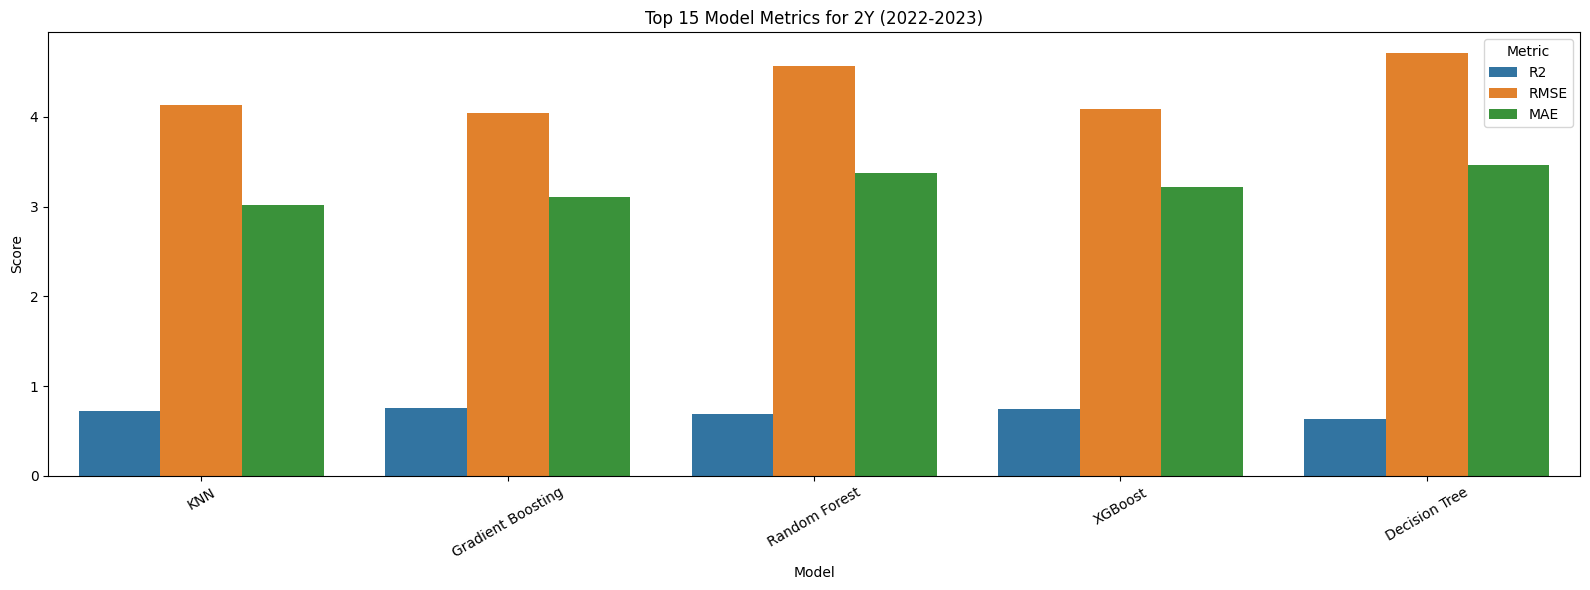


========== Results for 3Y (2021-2023) ==========

Top 15 Models by R²:


,Feature Set,Split,Outlier Handling,Model,R2,RMSE,MAE
181,Emission,80:20,Outliers Removed,XGBoost,0.642321,4.479810,3.261141
226,Combined,80:20,With Outliers,Random Forest,0.640585,4.378630,2.965158
237,Combined,80:20,Outliers Removed,XGBoost,0.637065,4.591371,3.300910
228,Combined,80:20,With Outliers,KNN,0.634914,4.413034,2.794886
236,Combined,80:20,Outliers Removed,Gradient Boosting,0.632289,4.621485,3.299268
177,Emission,80:20,Outliers Removed,Random Forest,0.631099,4.549543,3.402554
179,Emission,80:20,Outliers Removed,KNN,0.628614,4.564839,3.280347
242,Combined,70:30,With Outliers,KNN,0.625920,4.560010,3.017896
249,Combined,70:30,Outliers Removed,KNN,0.622698,4.978632,3.466927
191,Emission,70:30,Outliers Removed,Random Forest,0.621821,4.557019,3.349449


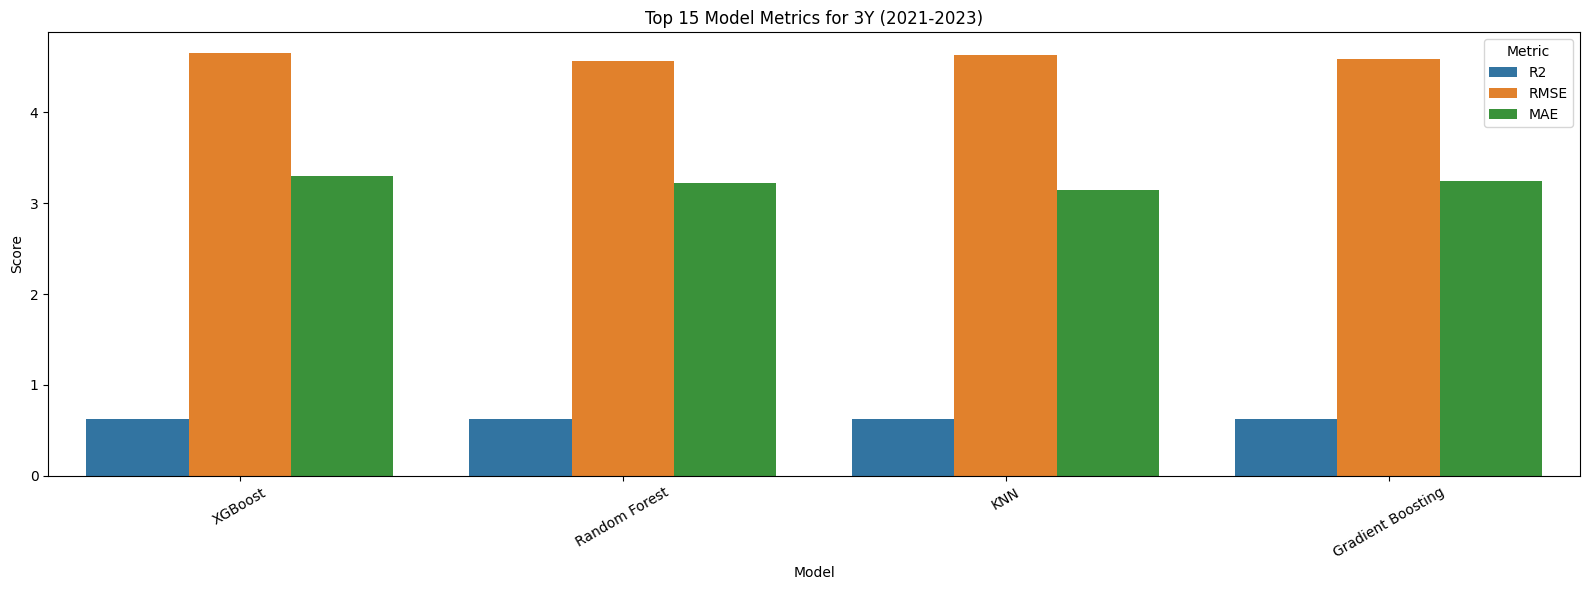

In [8]:
# -------------------------
# Process & Visualize Per Time Window
# -------------------------
metrics = ['R2', 'RMSE', 'MAE']

for time_label in results_df['Time Window'].unique():
    print(f"\n========== Results for {time_label} ==========")

    df_time = results_df[results_df['Time Window'] == time_label]
    df_top15 = df_time.sort_values(by='R2', ascending=False).head(15)

    print("\nTop 15 Models by R²:")
    display(df_top15[['Feature Set', 'Split', 'Outlier Handling', 'Model', 'R2', 'RMSE', 'MAE']])

    # Prepare for multibar plot
    melted = df_top15.melt(
        id_vars=['Model', 'Feature Set', 'Split', 'Outlier Handling'],
        value_vars=metrics,
        var_name='Metric', value_name='Score'
    )

    plt.figure(figsize=(16, 6))
    sns.barplot(data=melted, x='Model', y='Score', hue='Metric', ci=None)
    plt.title(f"Top 15 Model Metrics for {time_label}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.legend(title='Metric')
    plt.show()


Top 15 Results for: 1Y (2023)


,Time Window,Feature Set,Split,Outlier Handling,Model,MAE,MSE,RMSE,R2,Best Params
74,1Y (2023),Combined,70:30,With Outliers,KNN,2.557590,14.107246,3.755961,0.814960,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
60,1Y (2023),Combined,80:20,With Outliers,KNN,2.627356,13.877684,3.725276,0.813025,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
68,1Y (2023),Combined,80:20,Outliers Removed,Gradient Boosting,2.956268,16.874993,4.107918,0.780003,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
69,1Y (2023),Combined,80:20,Outliers Removed,XGBoost,2.790504,16.926492,4.114182,0.779331,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
32,1Y (2023),Meteorological,80:20,With Outliers,KNN,2.827449,16.618460,4.076575,0.776099,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
81,1Y (2023),Combined,70:30,Outliers Removed,KNN,2.864832,18.346080,4.283232,0.761356,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
18,1Y (2023),Emission,70:30,With Outliers,KNN,2.816353,18.512130,4.302572,0.757183,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
72,1Y (2023),Combined,70:30,With Outliers,Random Forest,2.998919,18.787109,4.334410,0.753576,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e..."
75,1Y (2023),Combined,70:30,With Outliers,Gradient Boosting,3.070759,19.185991,4.380182,0.748344,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
65,1Y (2023),Combined,80:20,Outliers Removed,Random Forest,3.031097,20.418173,4.518647,0.733811,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e..."


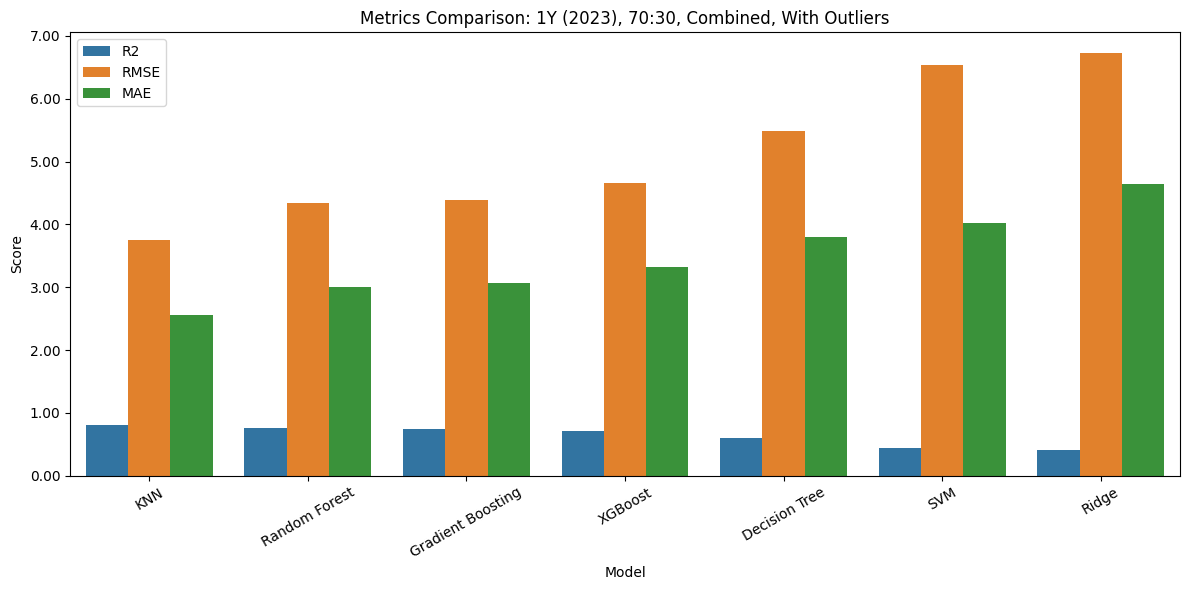

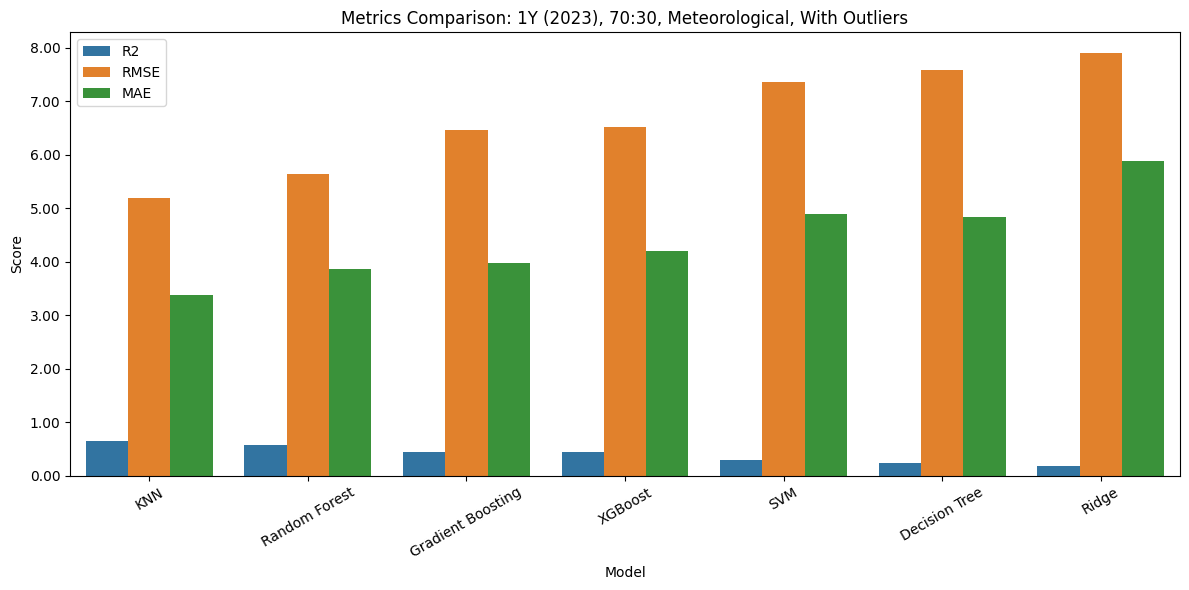

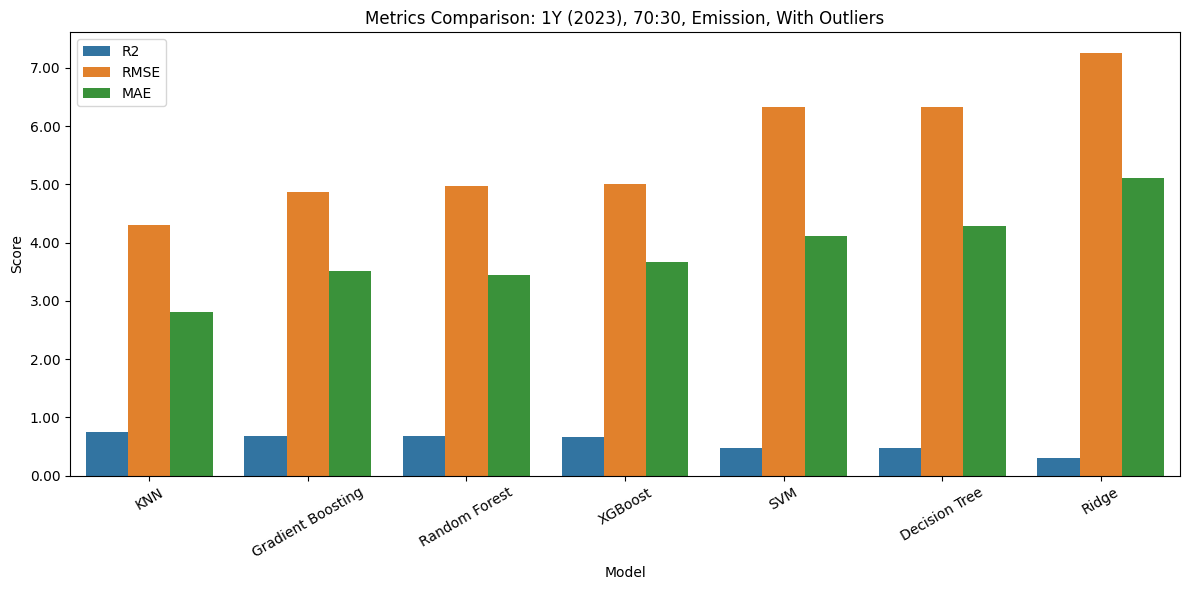

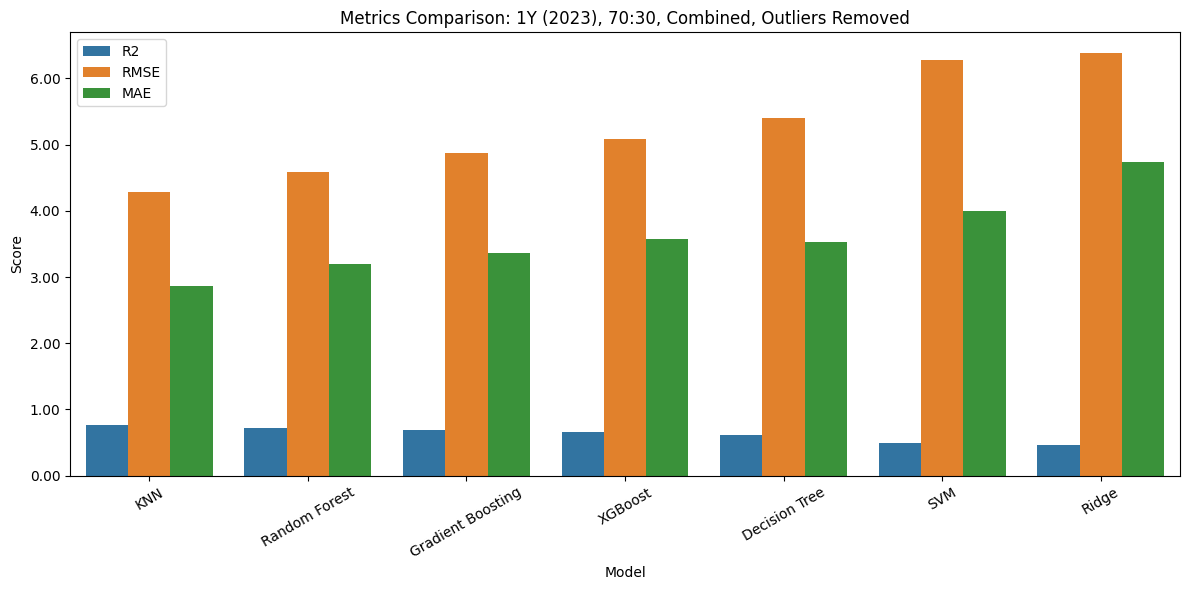

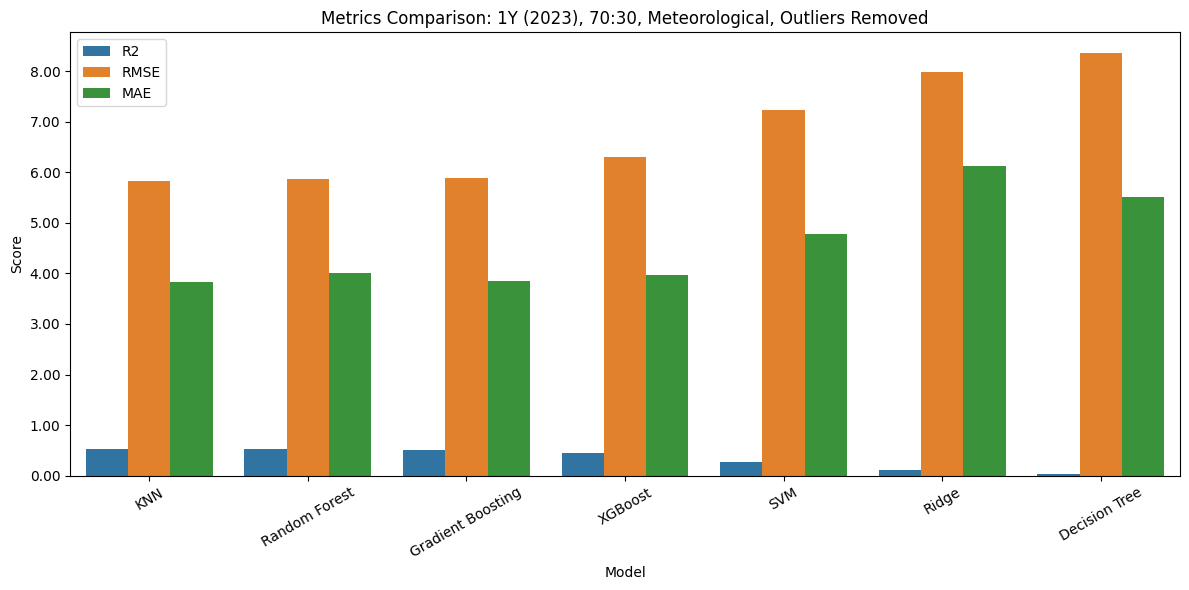

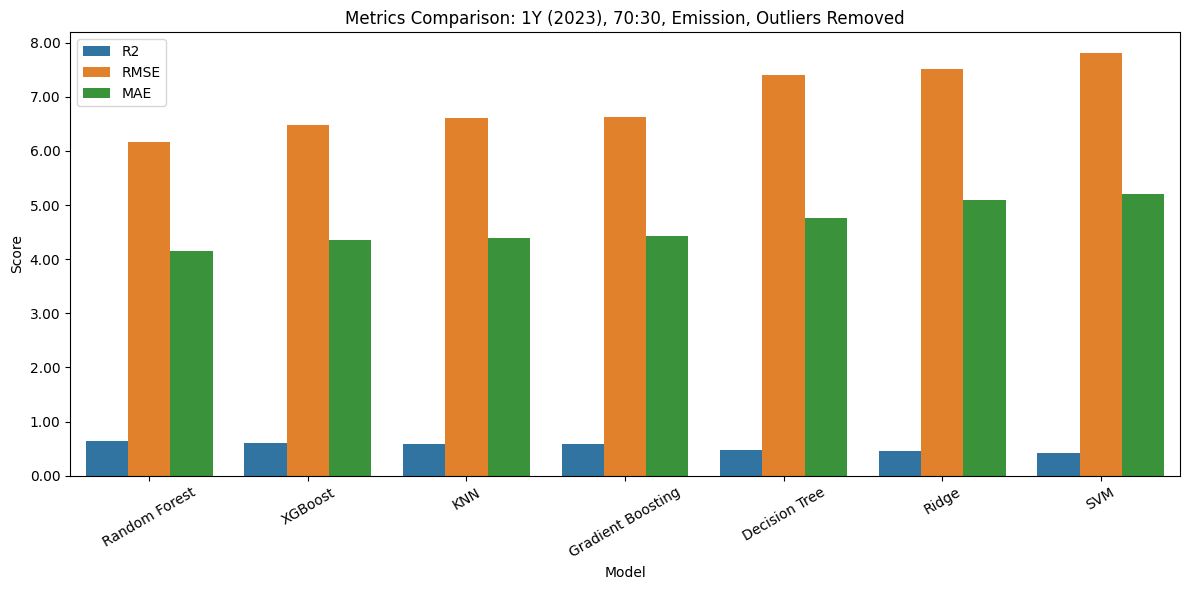

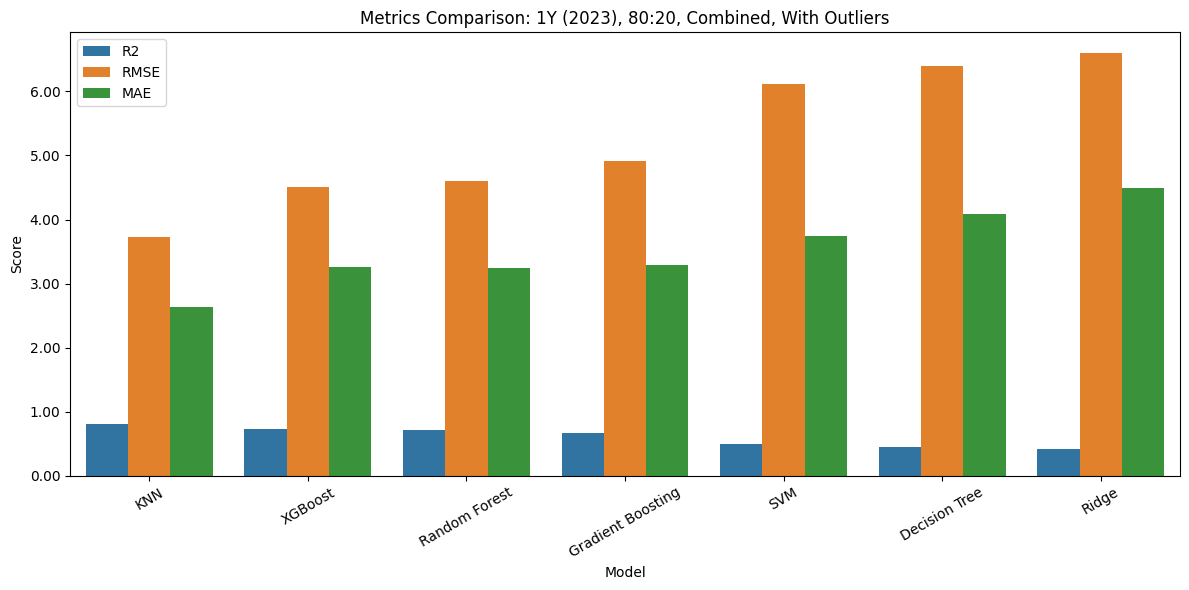

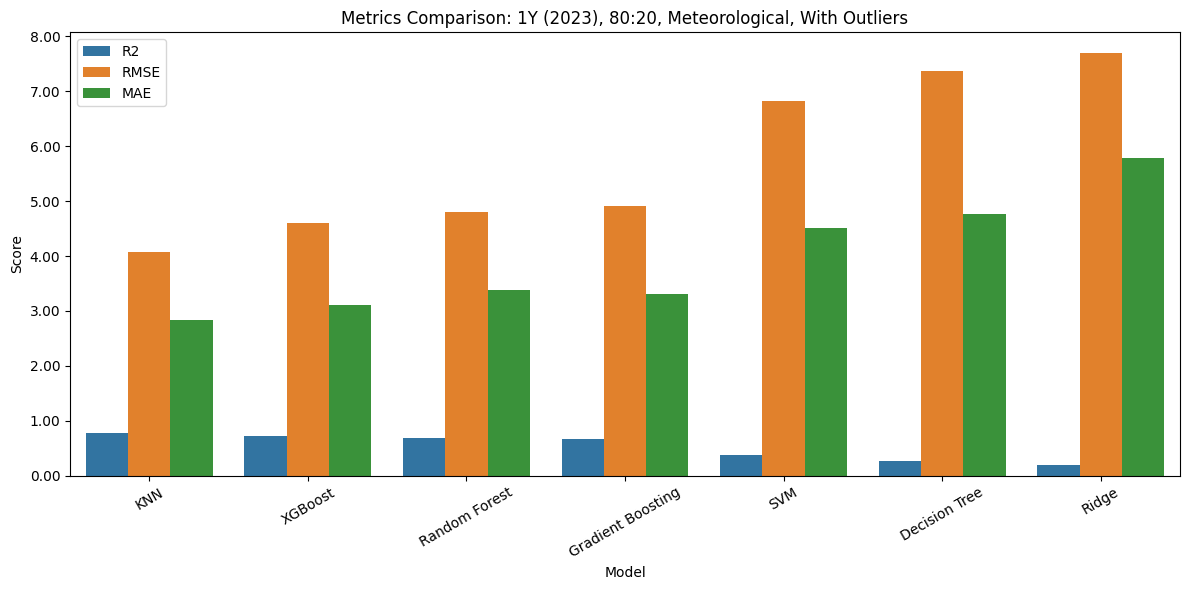

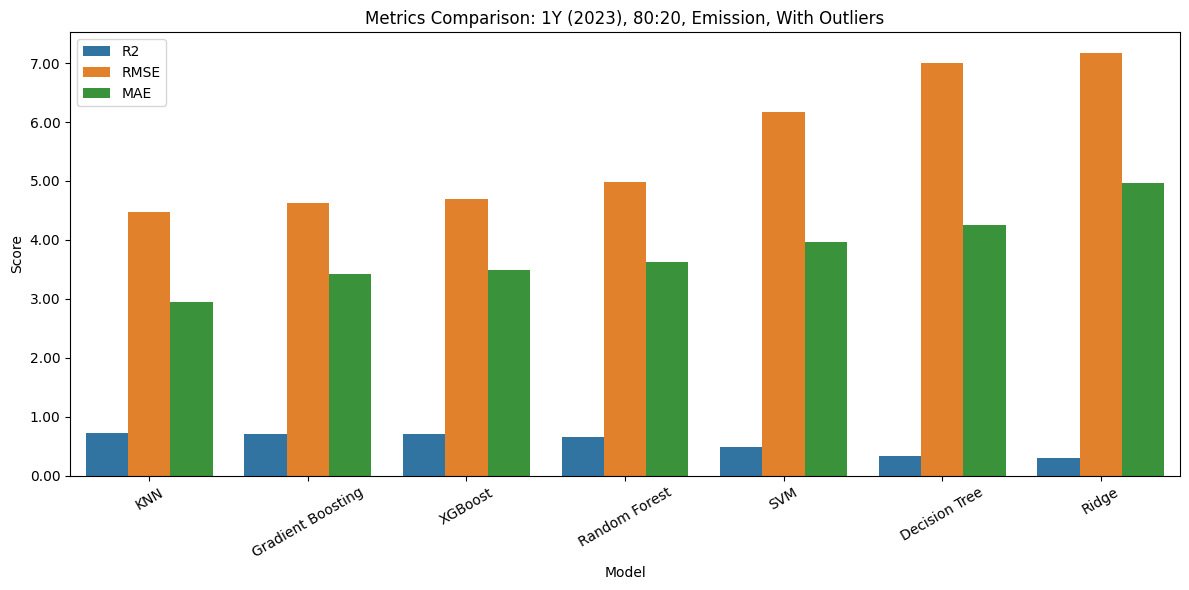

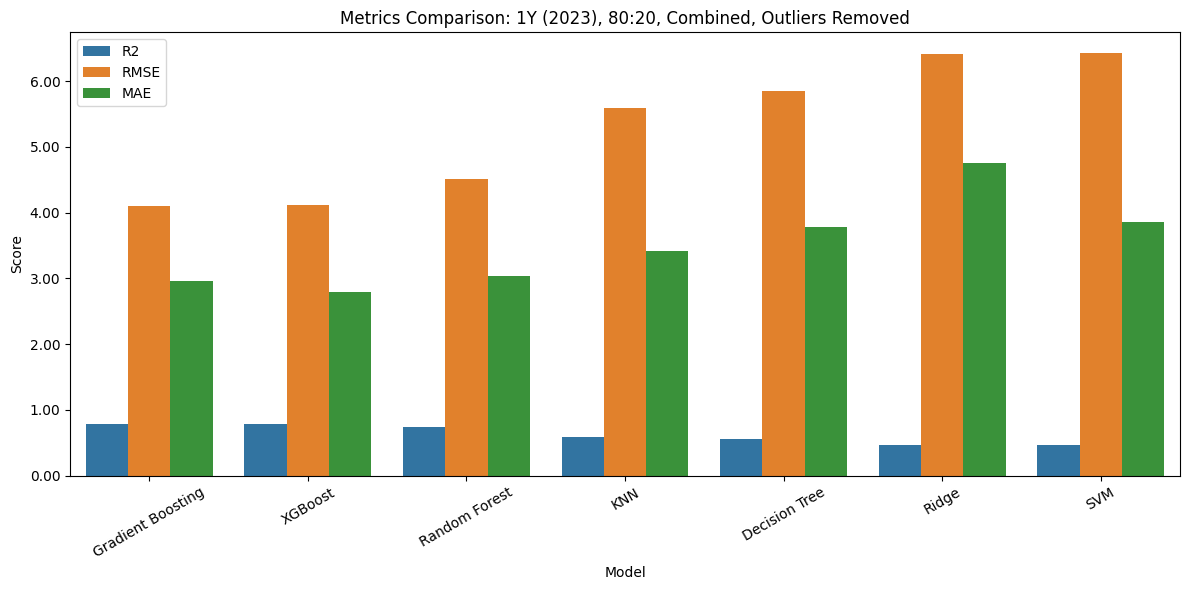

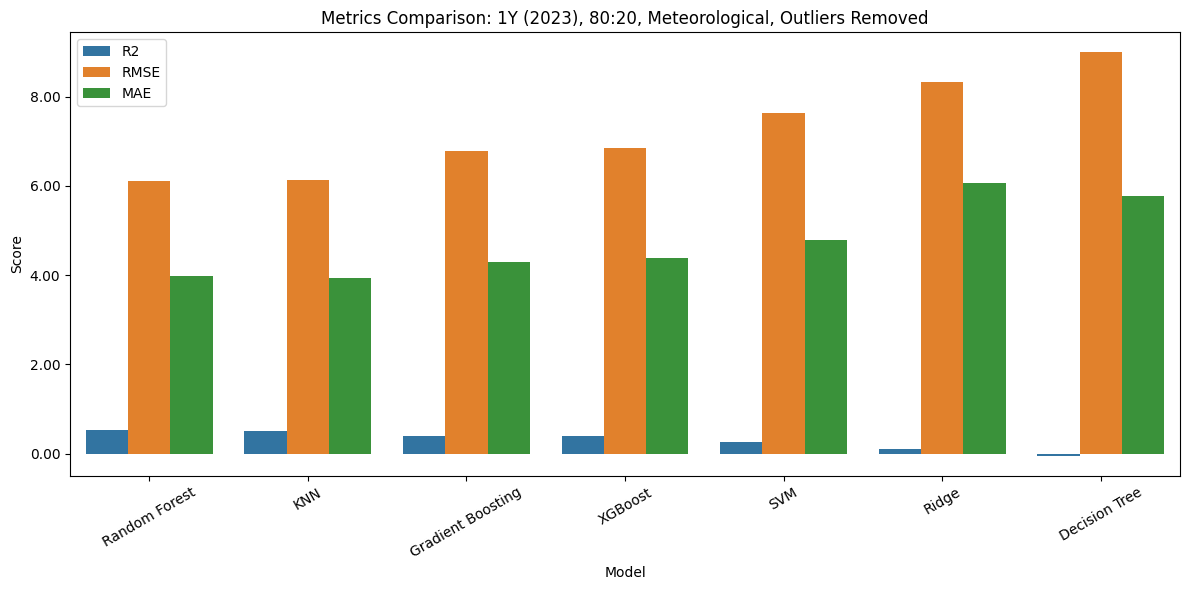

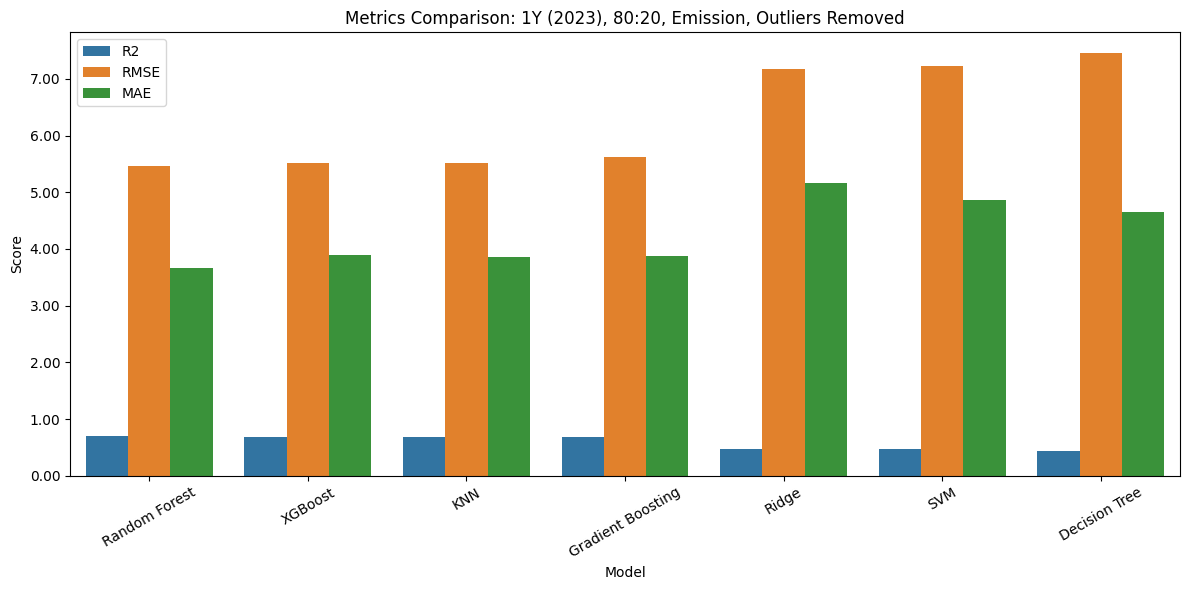

Top 15 Results for: 2Y (2022-2023)


,Time Window,Feature Set,Split,Outlier Handling,Model,MAE,MSE,RMSE,R2,Best Params
144,2Y (2022-2023),Combined,80:20,With Outliers,KNN,2.846488,14.049946,3.748326,0.800766,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
159,2Y (2022-2023),Combined,70:30,With Outliers,Gradient Boosting,2.922874,14.977322,3.870054,0.754107,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
142,2Y (2022-2023),Combined,80:20,With Outliers,Random Forest,3.164368,17.387254,4.169803,0.753442,"{'max_depth': 20, 'max_features': None, 'n_est..."
146,2Y (2022-2023),Combined,80:20,With Outliers,XGBoost,3.340814,17.739382,4.211815,0.748449,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
145,2Y (2022-2023),Combined,80:20,With Outliers,Gradient Boosting,3.291802,17.810995,4.220308,0.747433,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
160,2Y (2022-2023),Combined,70:30,With Outliers,XGBoost,3.100502,15.692025,3.961316,0.742373,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
156,2Y (2022-2023),Combined,70:30,With Outliers,Random Forest,3.164216,16.815238,4.100639,0.723932,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e..."
88,2Y (2022-2023),Emission,80:20,With Outliers,KNN,3.324771,20.221561,4.496839,0.713250,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}"
158,2Y (2022-2023),Combined,70:30,With Outliers,KNN,3.024353,18.006519,4.243409,0.704374,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
86,2Y (2022-2023),Emission,80:20,With Outliers,Random Forest,3.471569,21.155122,4.599470,0.700012,"{'max_depth': 20, 'max_features': None, 'n_est..."


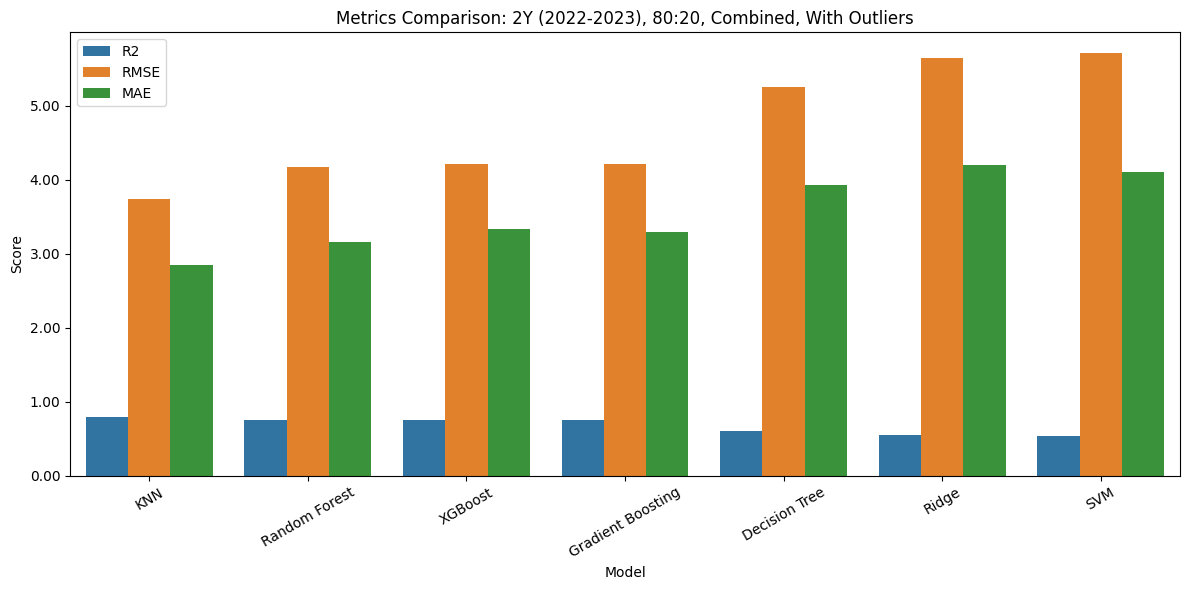

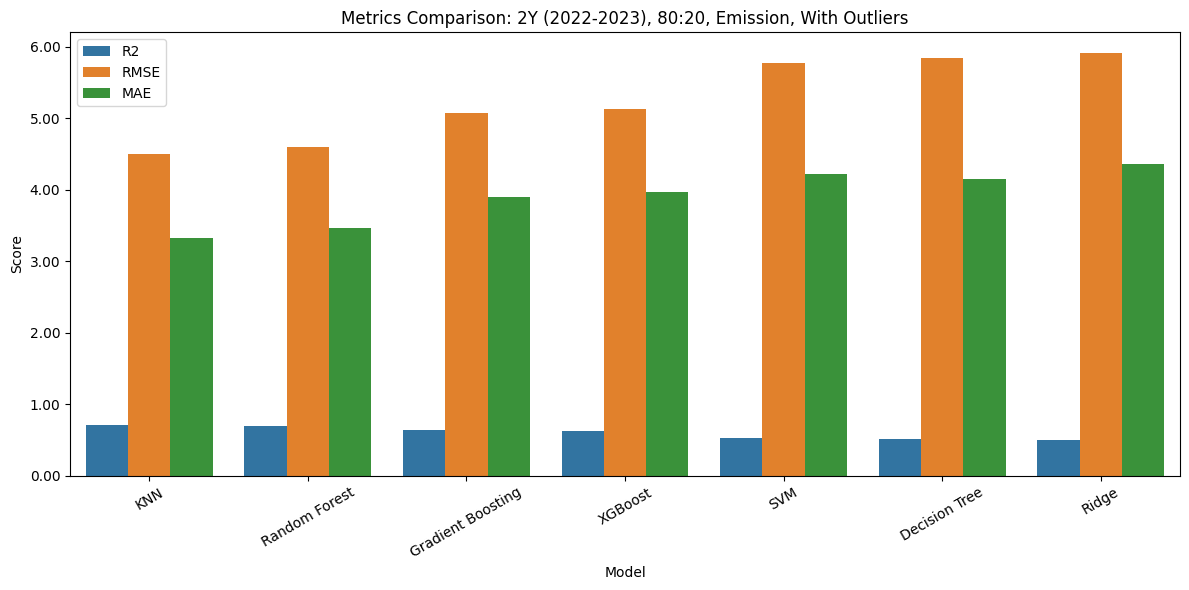

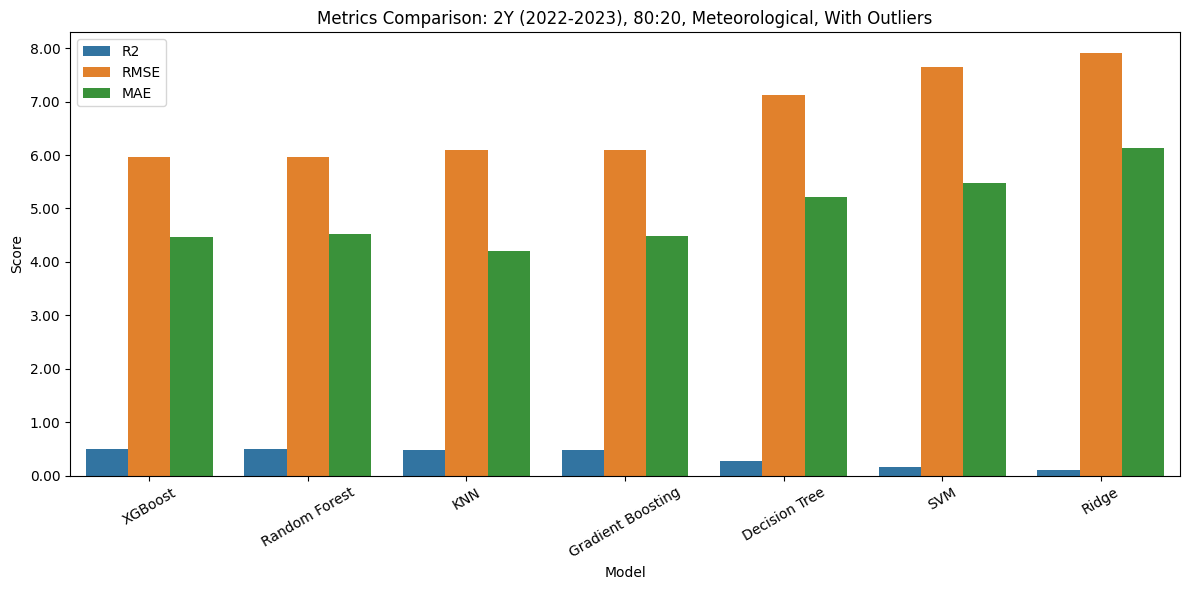

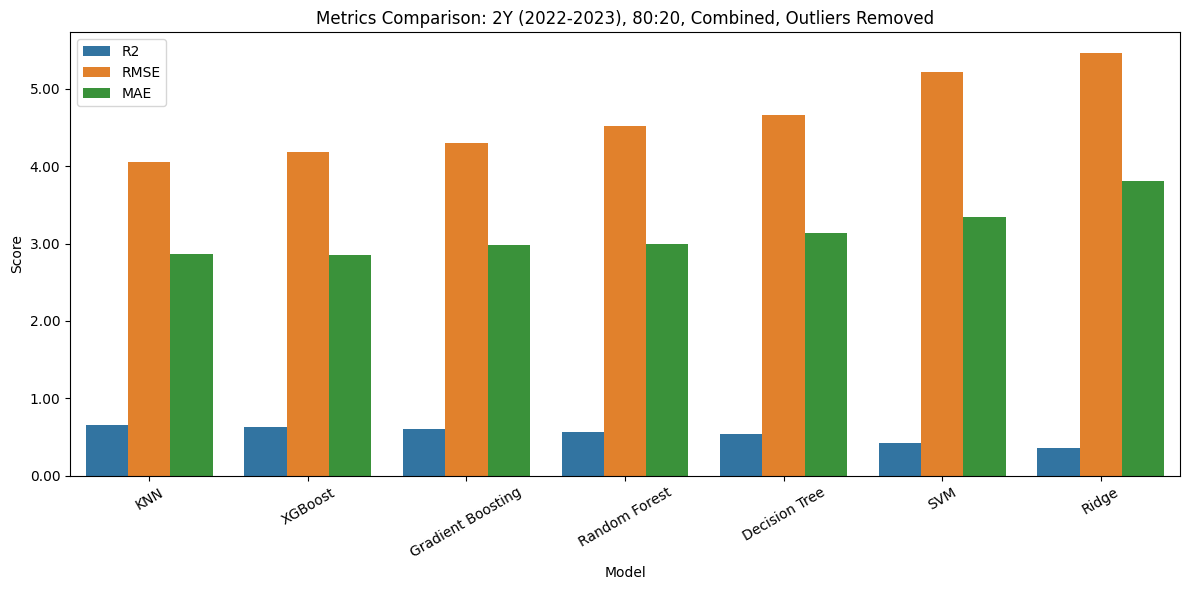

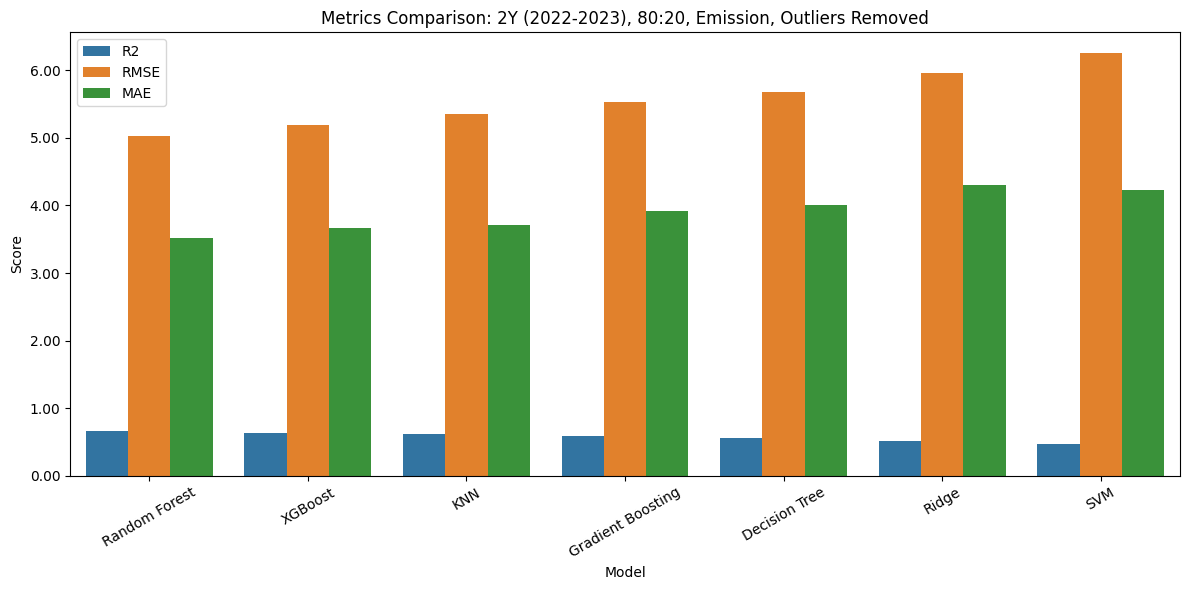

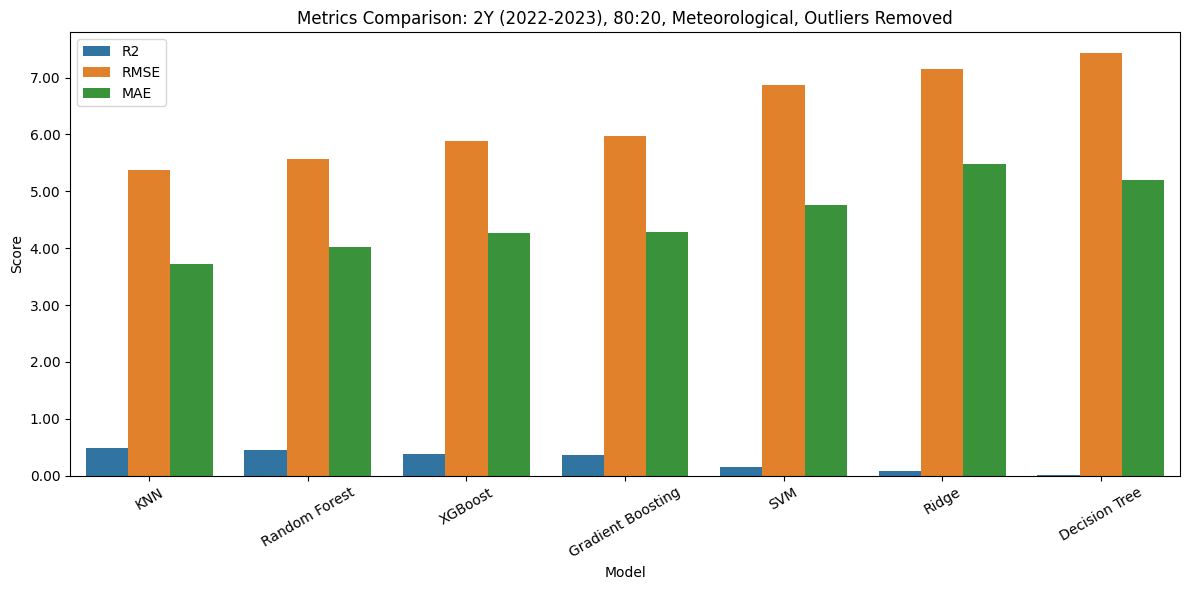

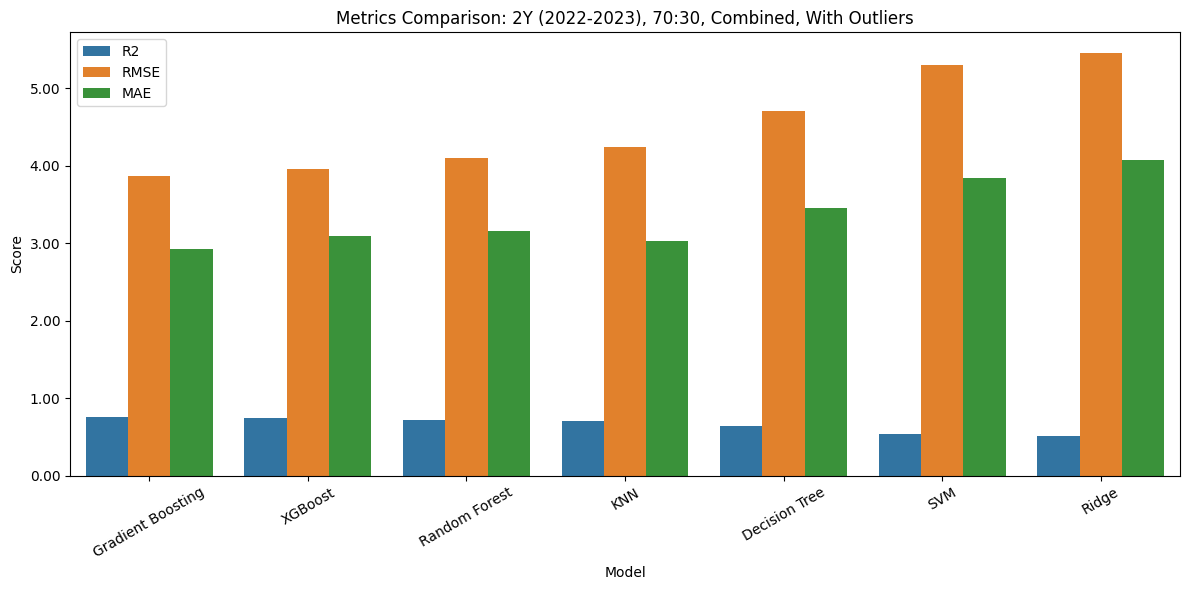

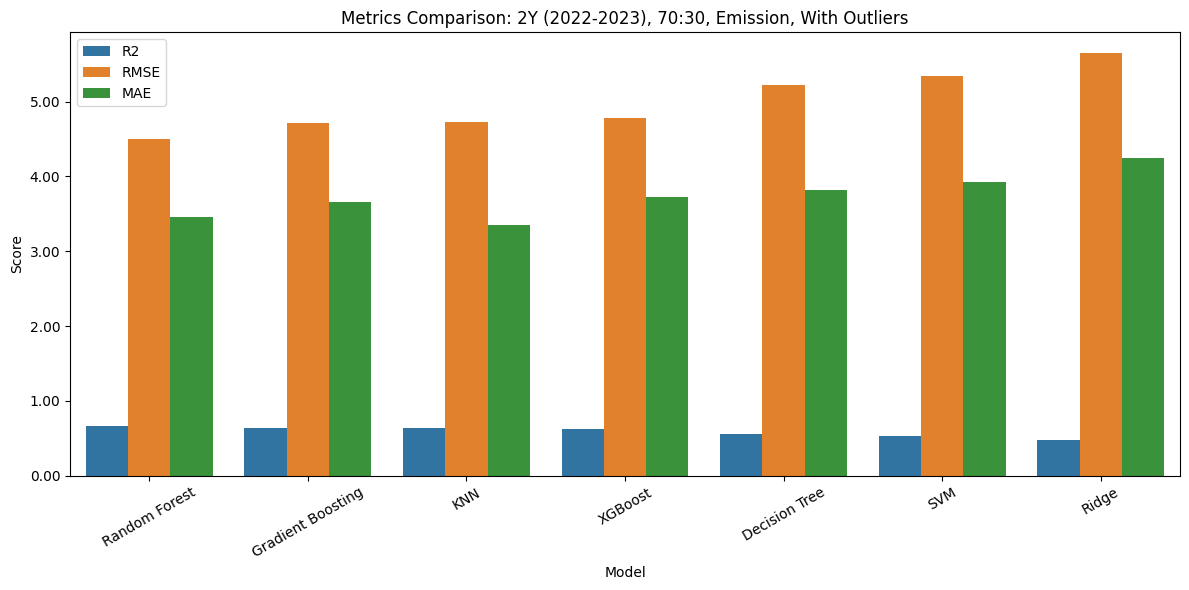

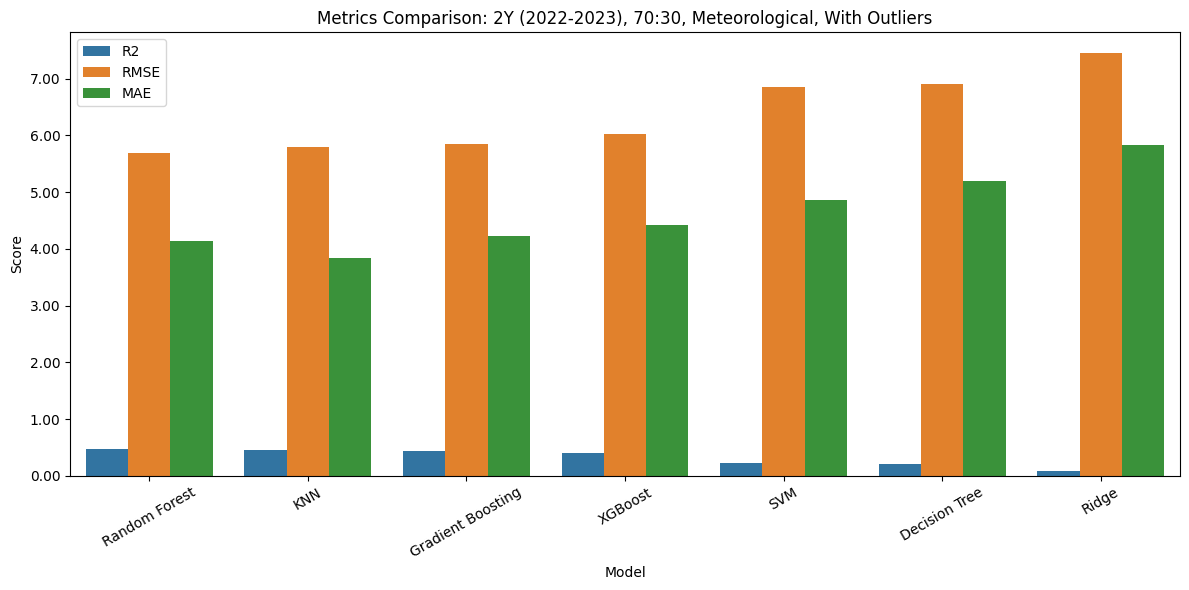

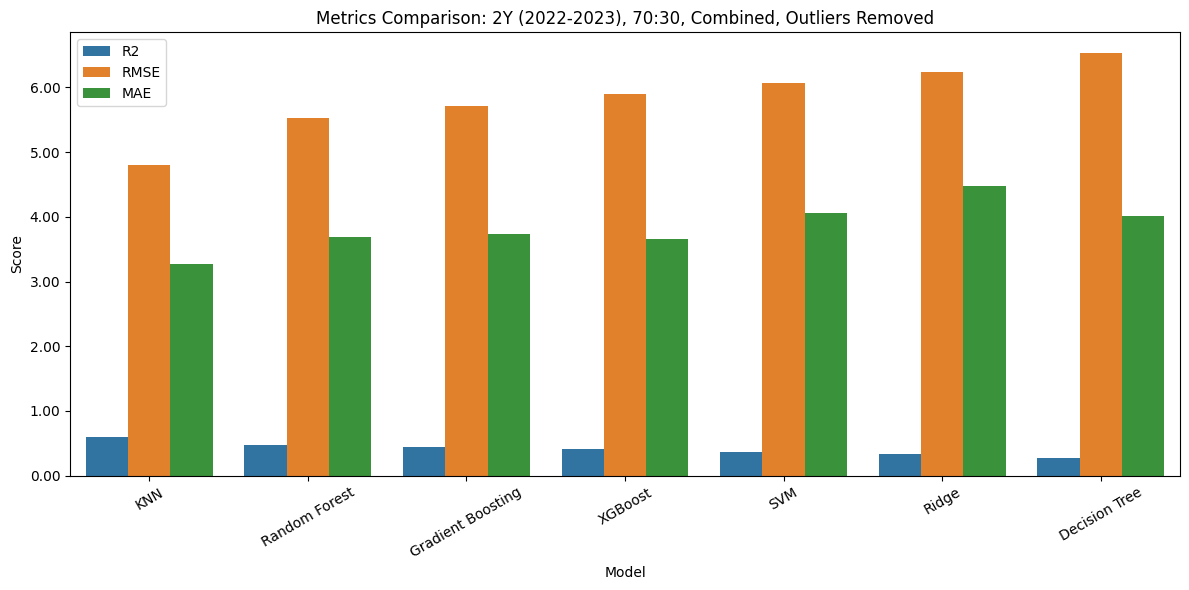

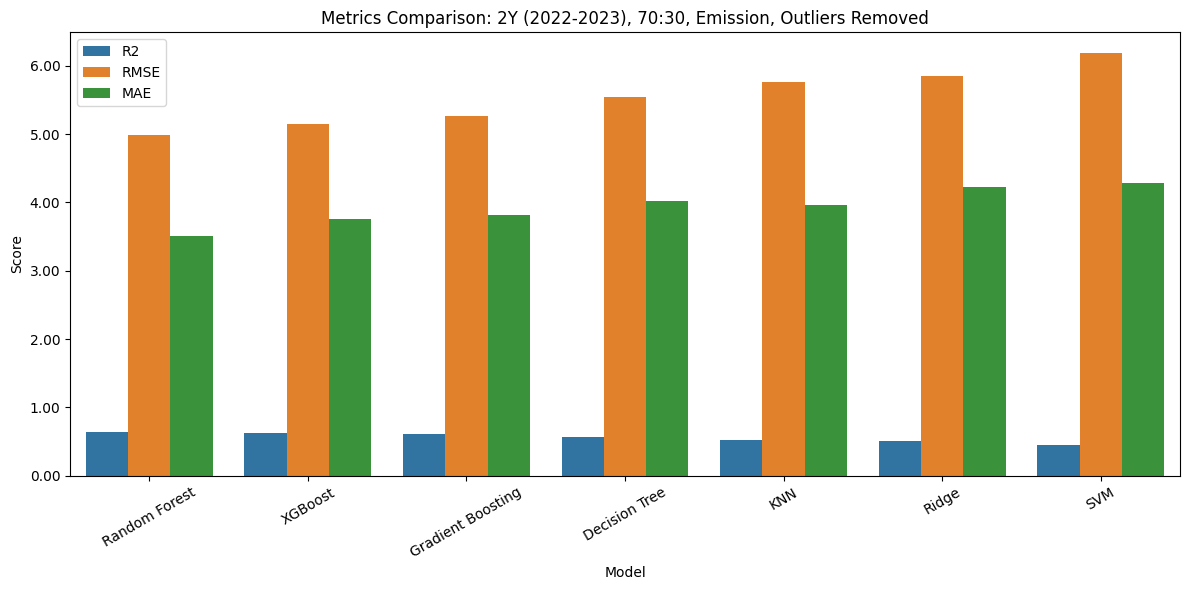

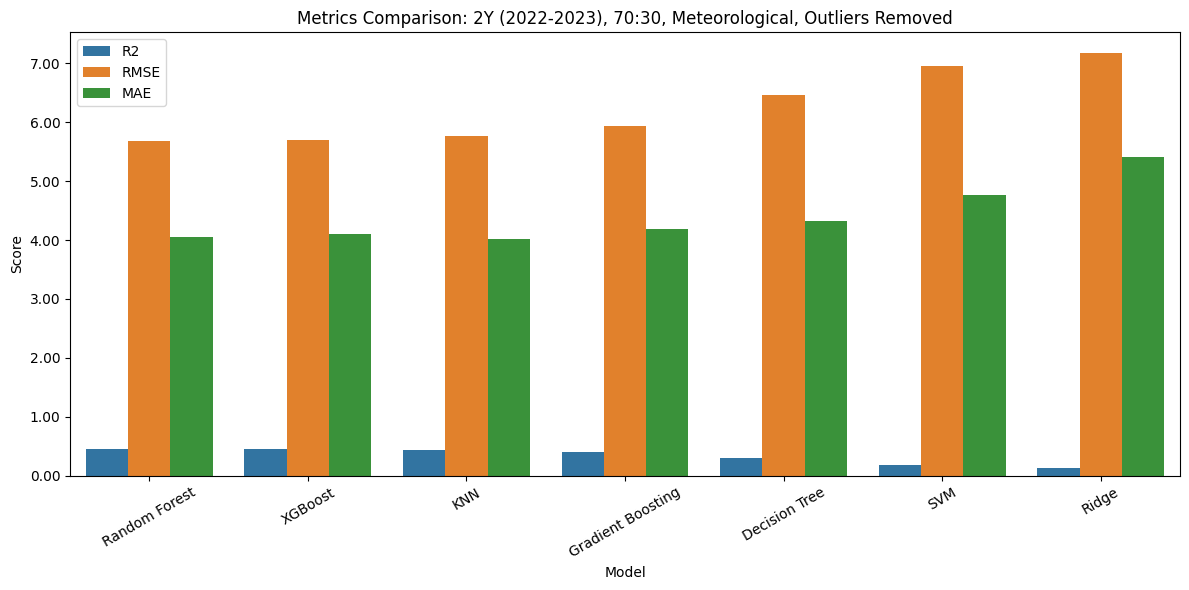

Top 15 Results for: 3Y (2021-2023)


,Time Window,Feature Set,Split,Outlier Handling,Model,MAE,MSE,RMSE,R2,Best Params
181,3Y (2021-2023),Emission,80:20,Outliers Removed,XGBoost,3.261141,20.068695,4.479810,0.642321,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
226,3Y (2021-2023),Combined,80:20,With Outliers,Random Forest,2.965158,19.172400,4.378630,0.640585,"{'max_depth': 20, 'max_features': None, 'n_est..."
237,3Y (2021-2023),Combined,80:20,Outliers Removed,XGBoost,3.300910,21.080685,4.591371,0.637065,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
228,3Y (2021-2023),Combined,80:20,With Outliers,KNN,2.794886,19.474870,4.413034,0.634914,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
236,3Y (2021-2023),Combined,80:20,Outliers Removed,Gradient Boosting,3.299268,21.358121,4.621485,0.632289,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
177,3Y (2021-2023),Emission,80:20,Outliers Removed,Random Forest,3.402554,20.698338,4.549543,0.631099,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e..."
179,3Y (2021-2023),Emission,80:20,Outliers Removed,KNN,3.280347,20.837759,4.564839,0.628614,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
242,3Y (2021-2023),Combined,70:30,With Outliers,KNN,3.017896,20.793694,4.560010,0.625920,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
249,3Y (2021-2023),Combined,70:30,Outliers Removed,KNN,3.466927,24.786775,4.978632,0.622698,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
191,3Y (2021-2023),Emission,70:30,Outliers Removed,Random Forest,3.349449,20.766423,4.557019,0.621821,"{'max_depth': 20, 'max_features': None, 'n_est..."


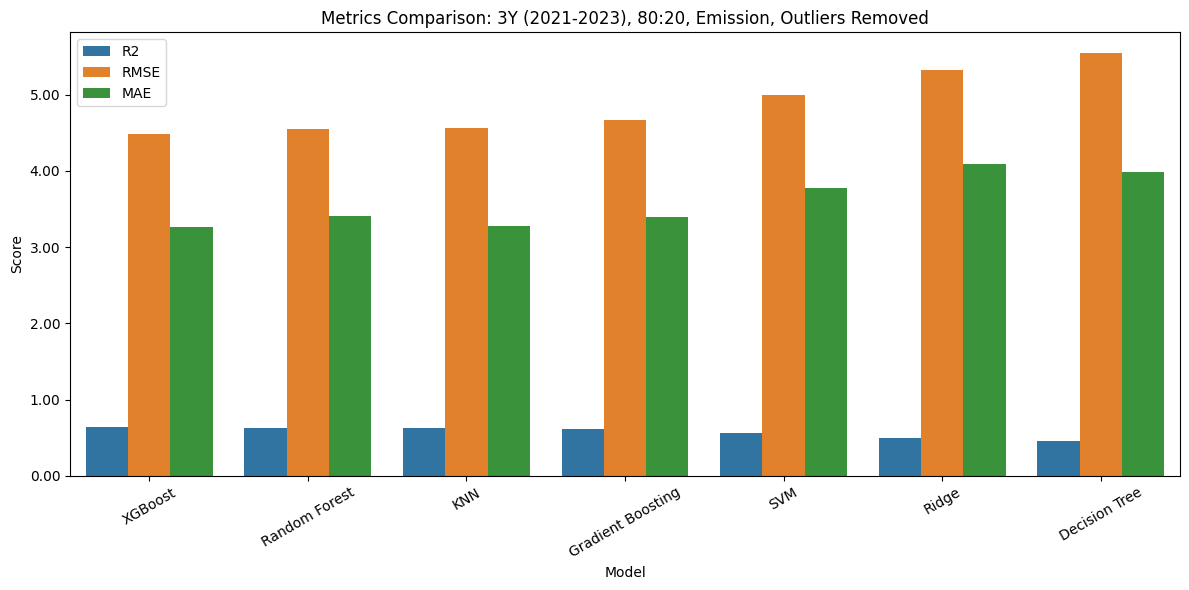

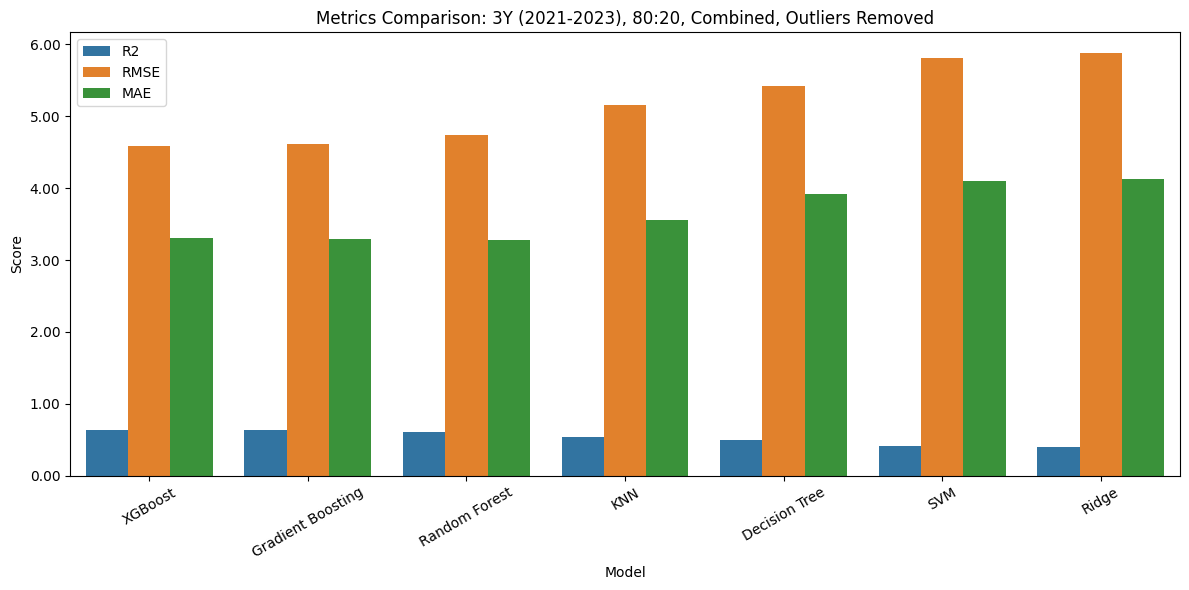

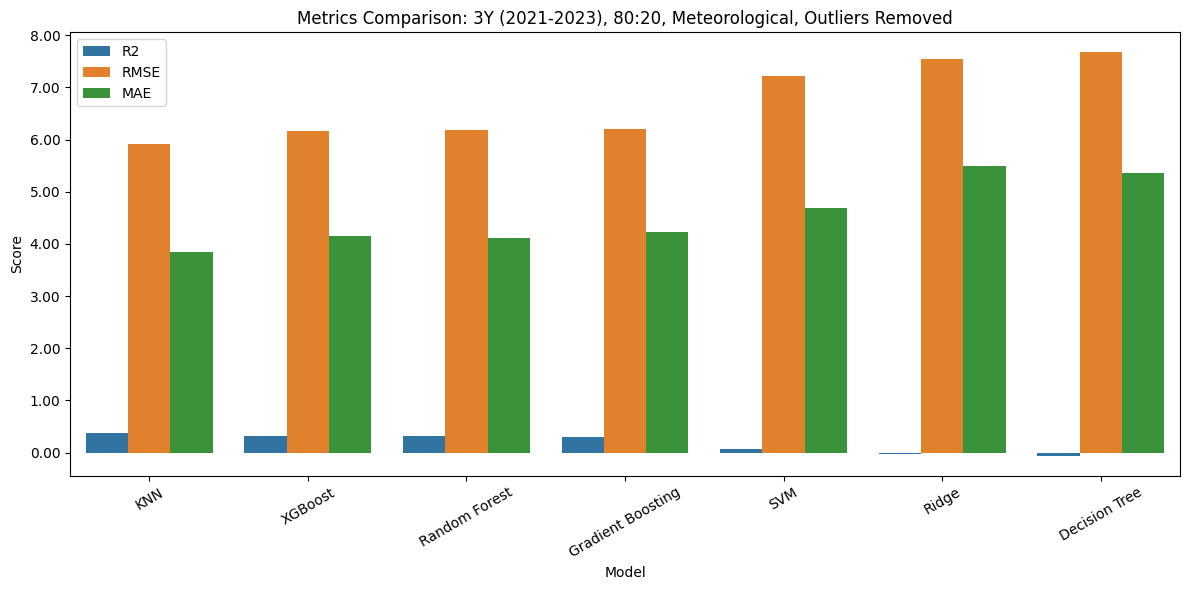

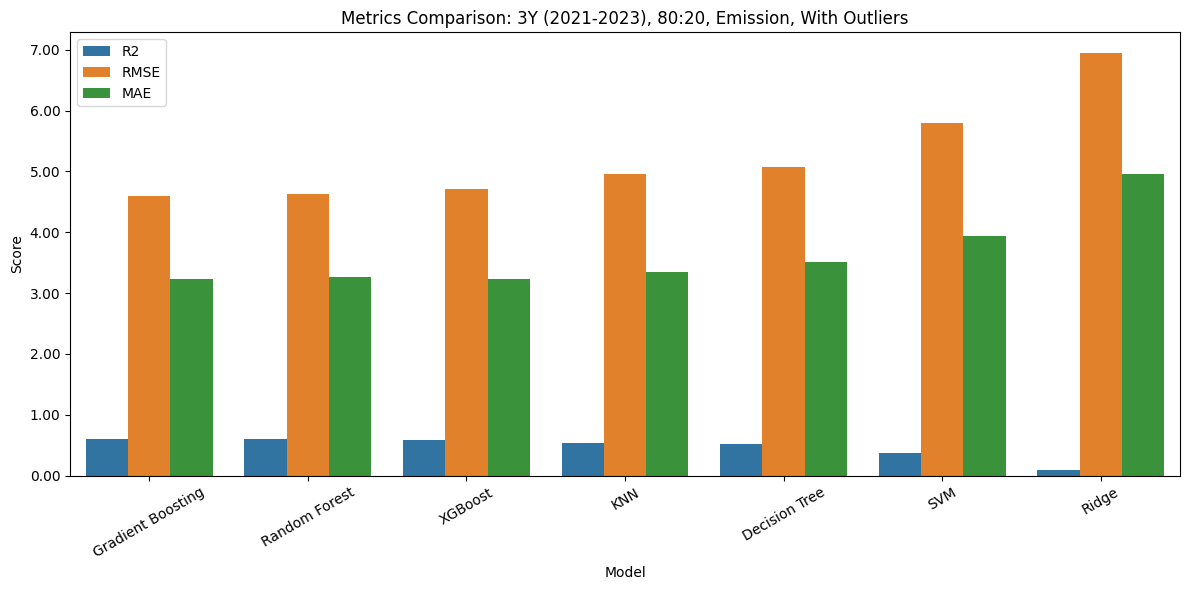

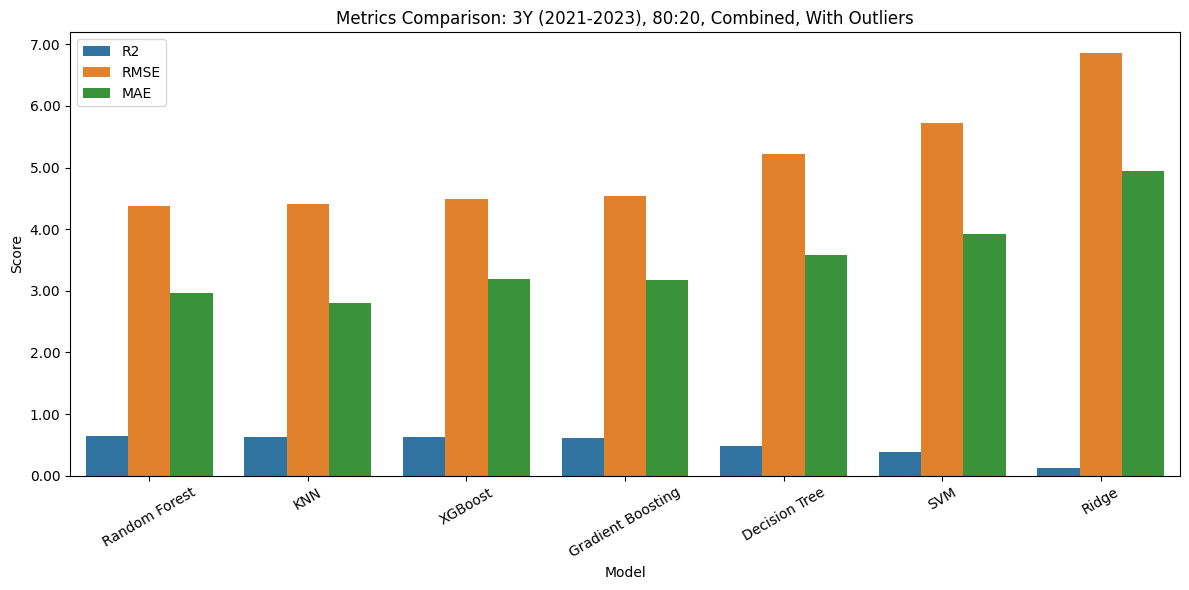

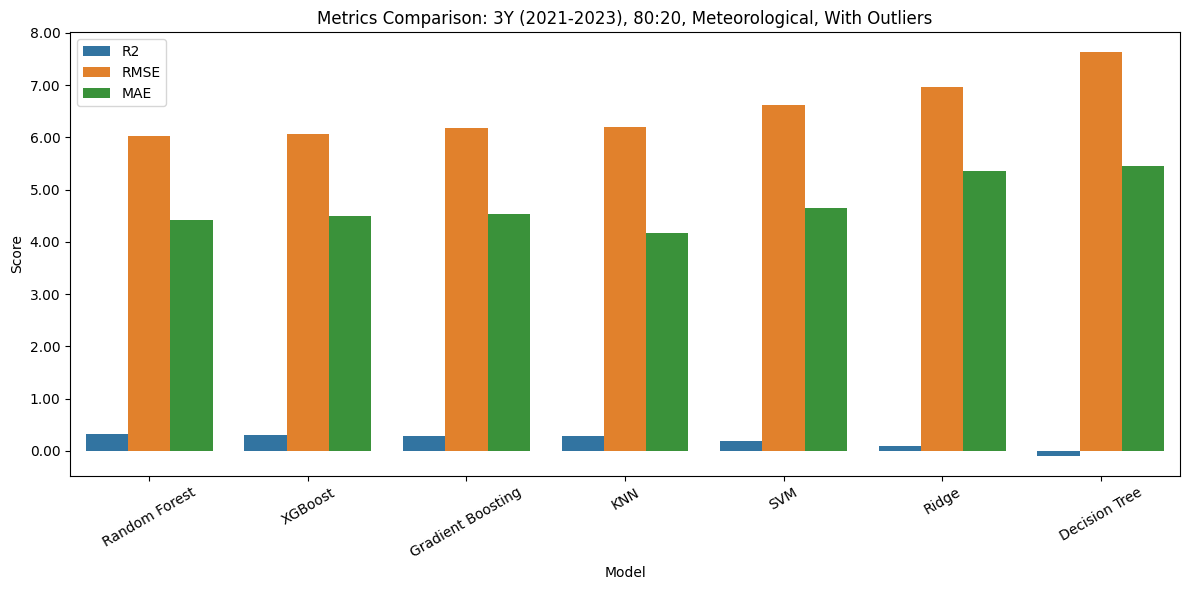

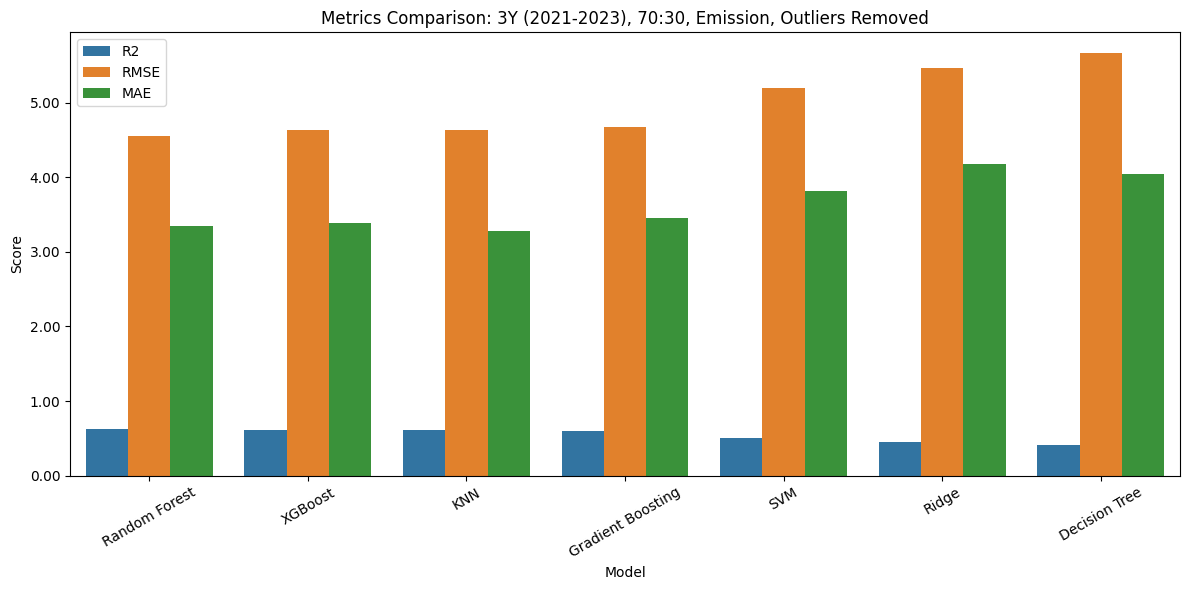

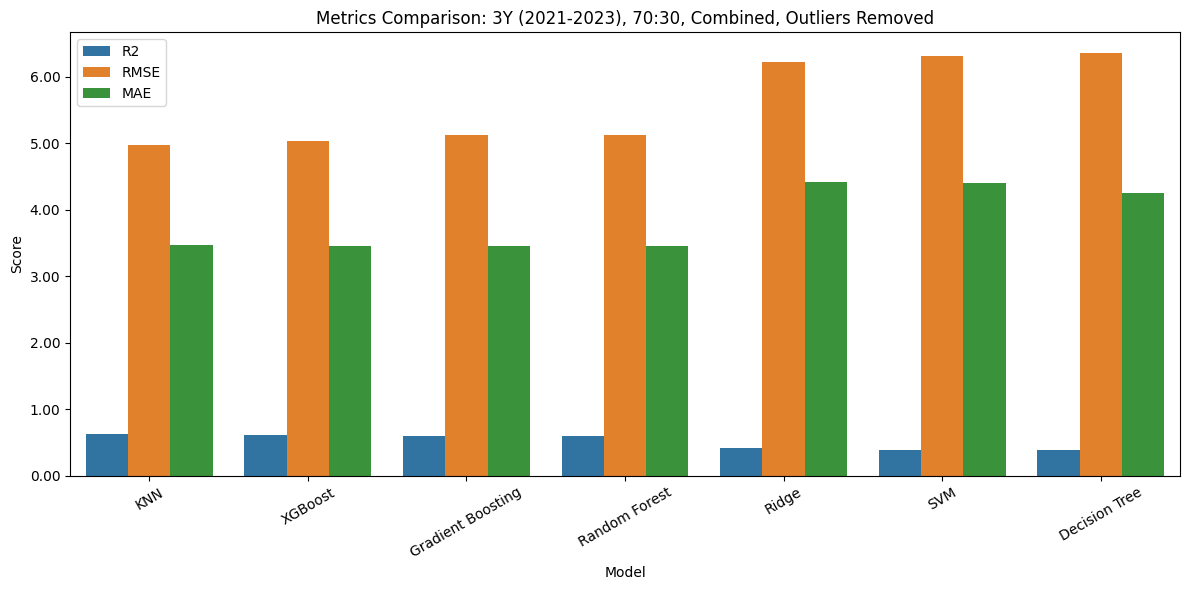

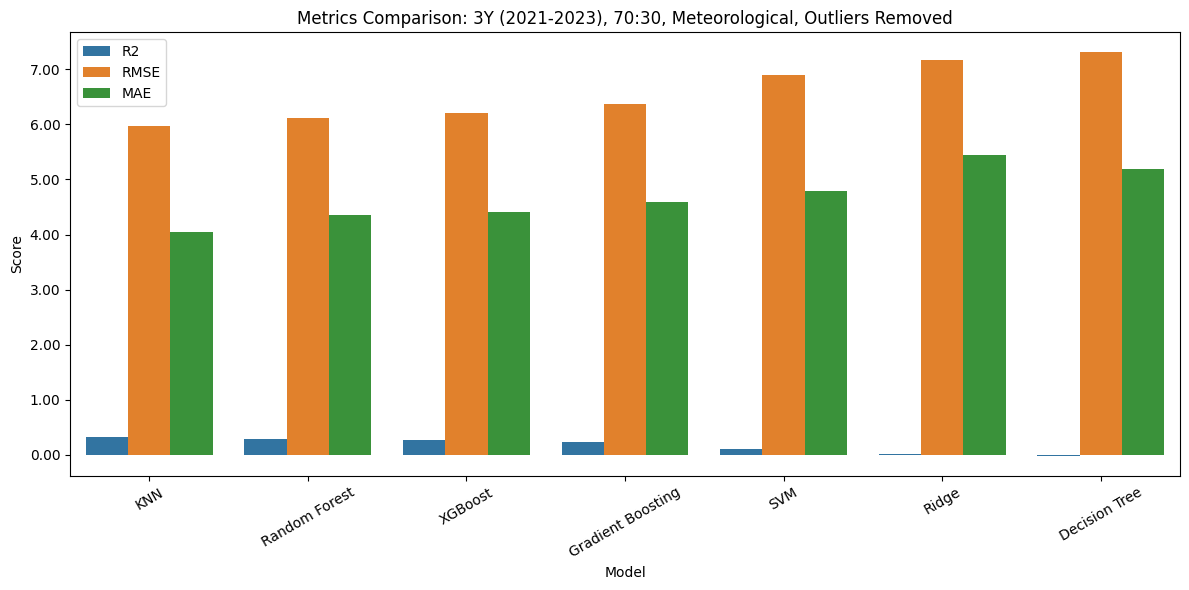

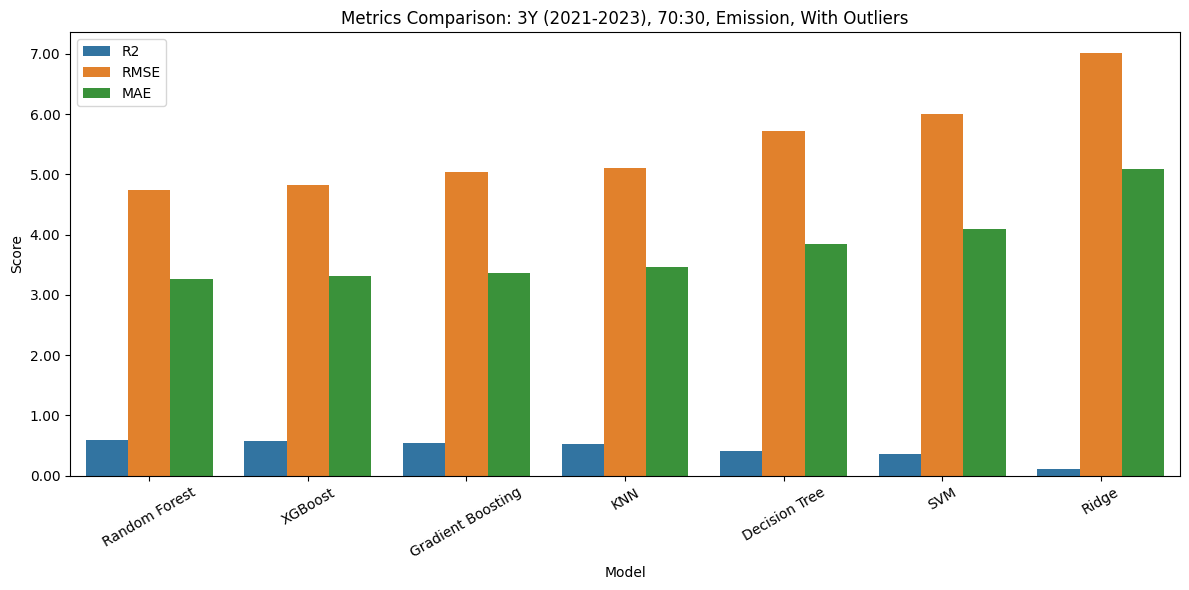

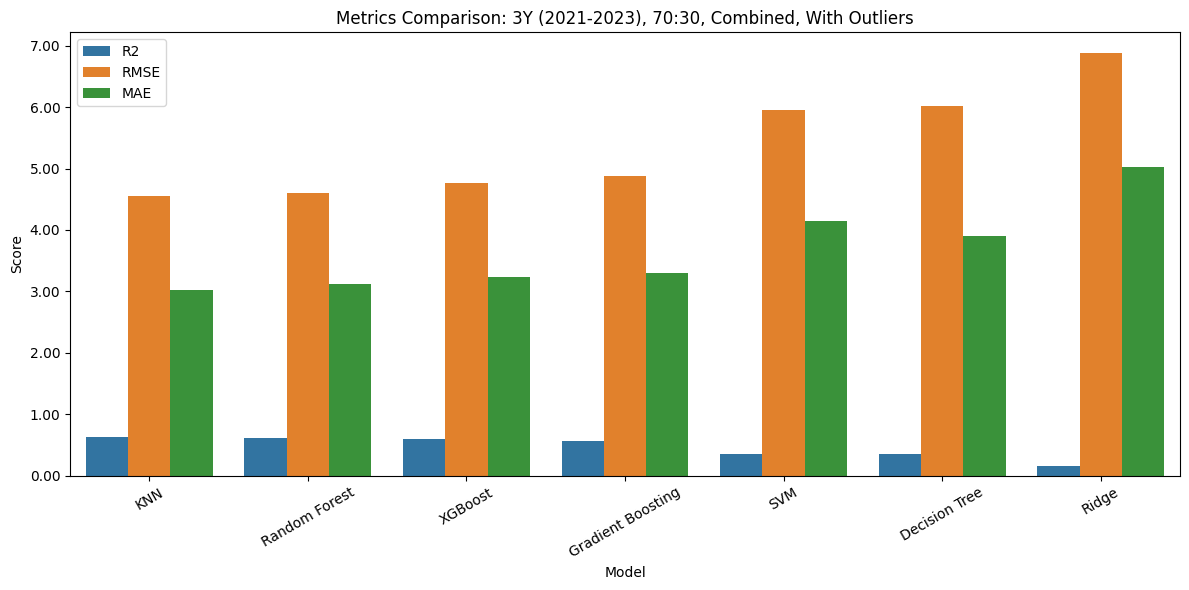

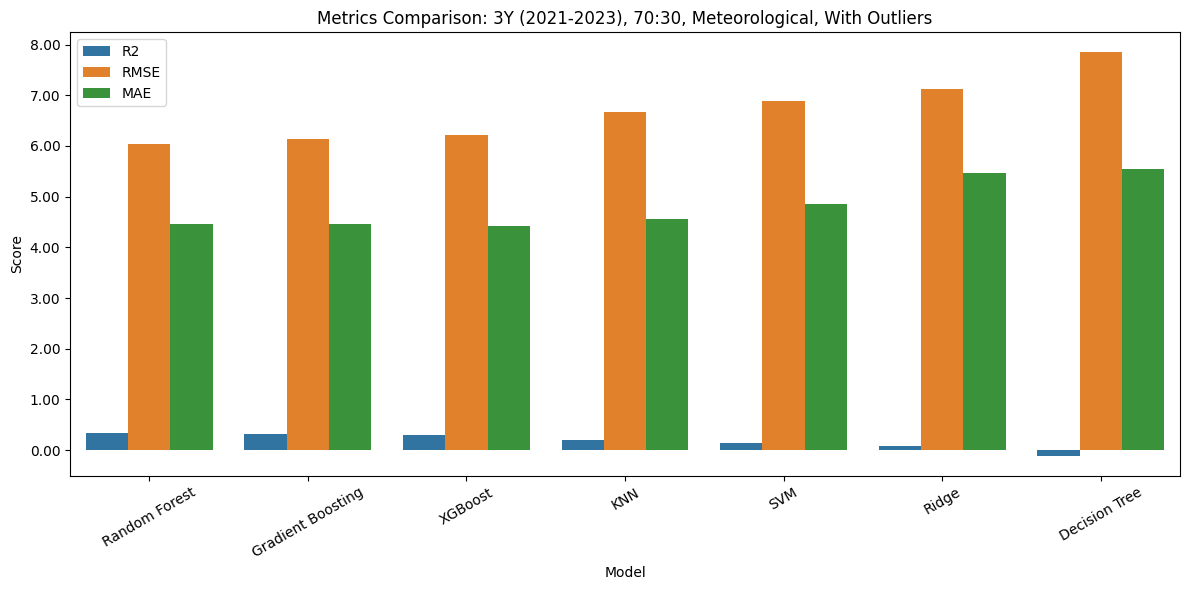

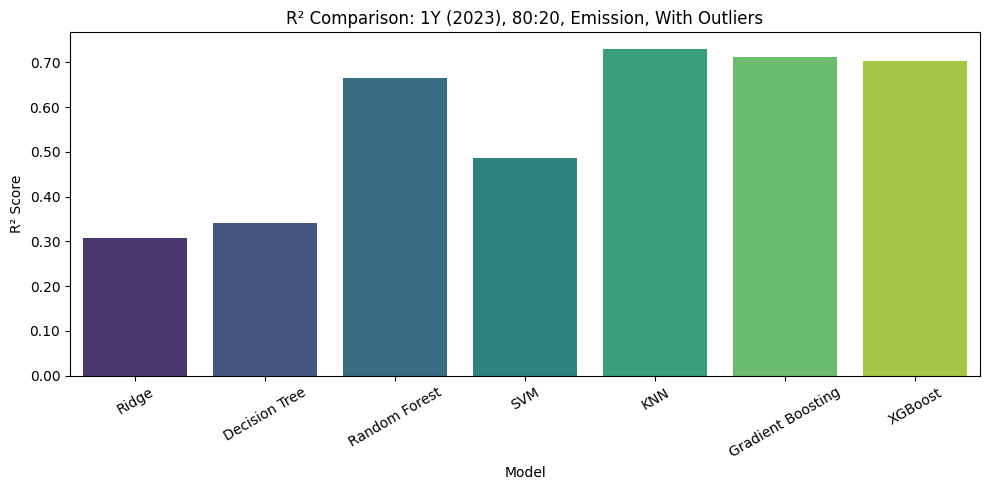

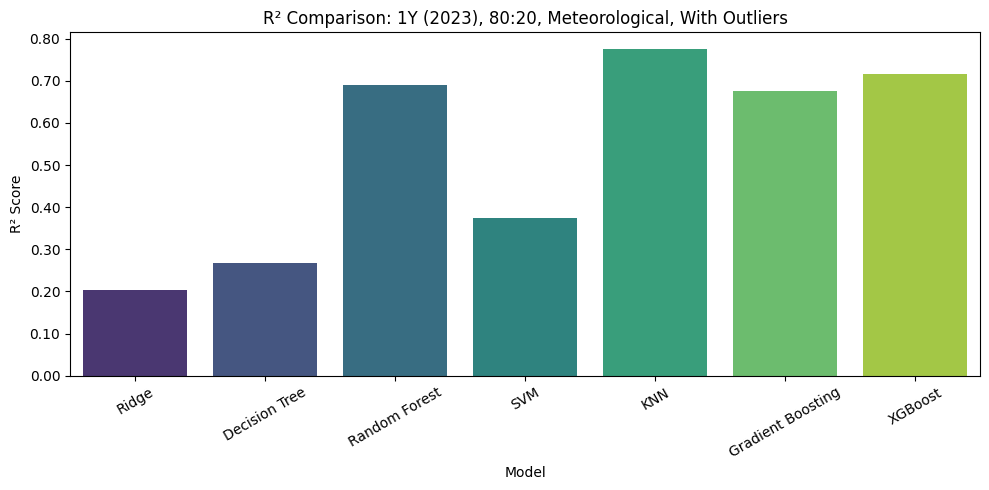

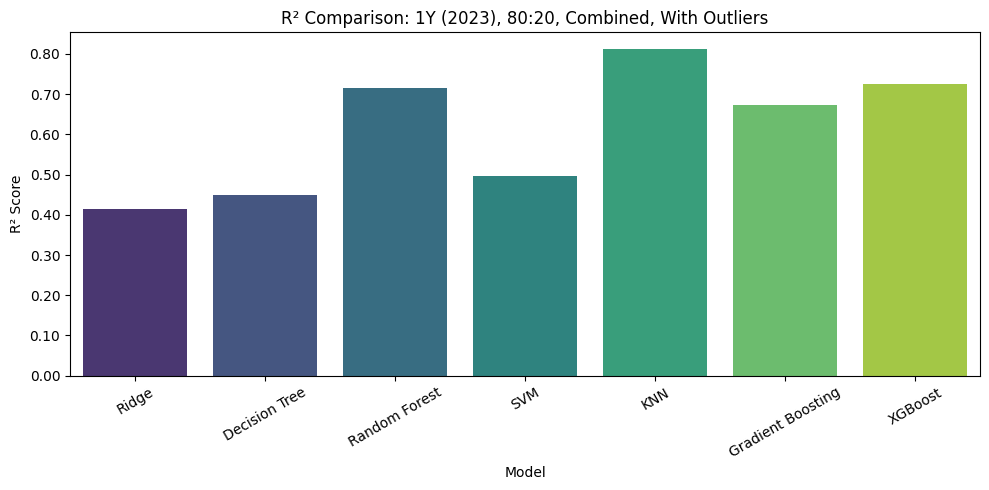

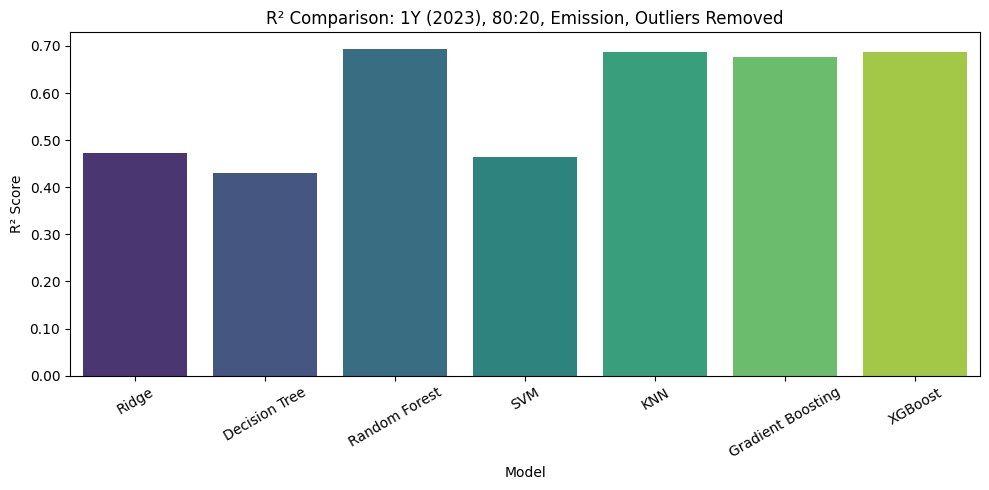

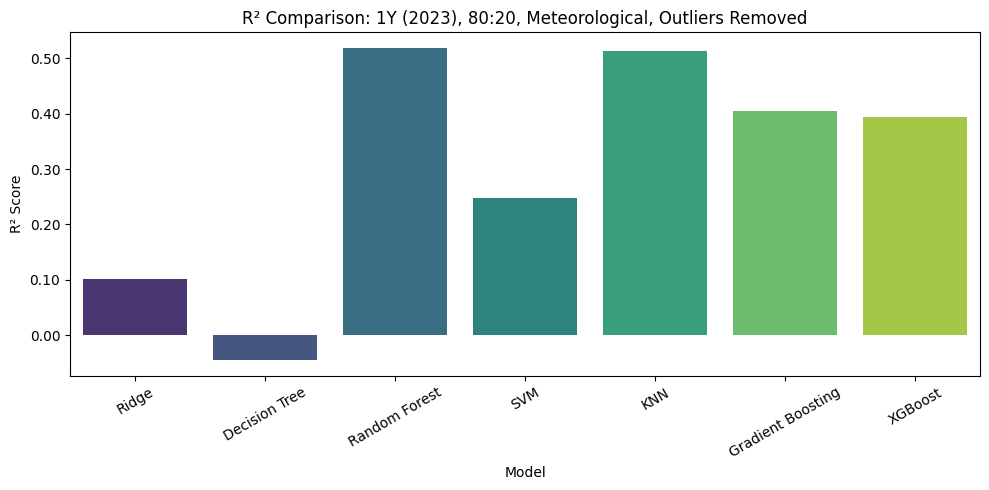

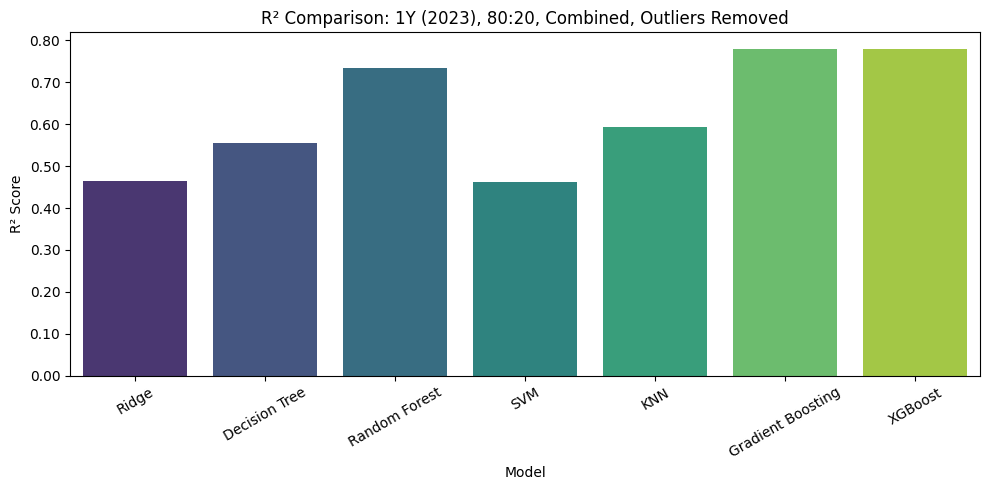

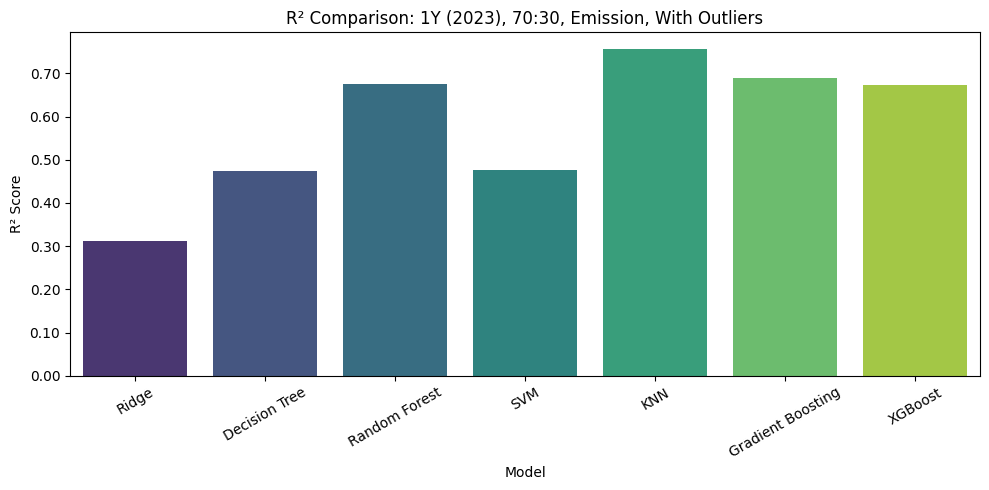

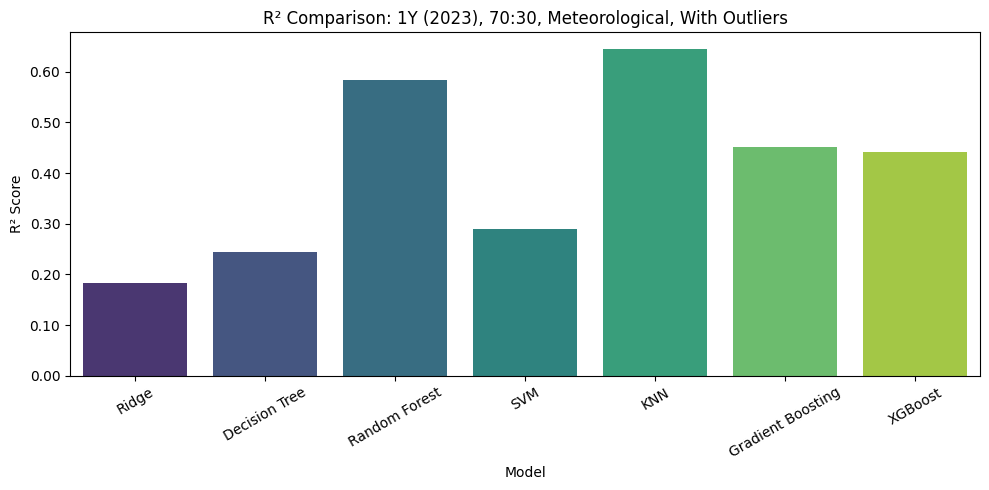

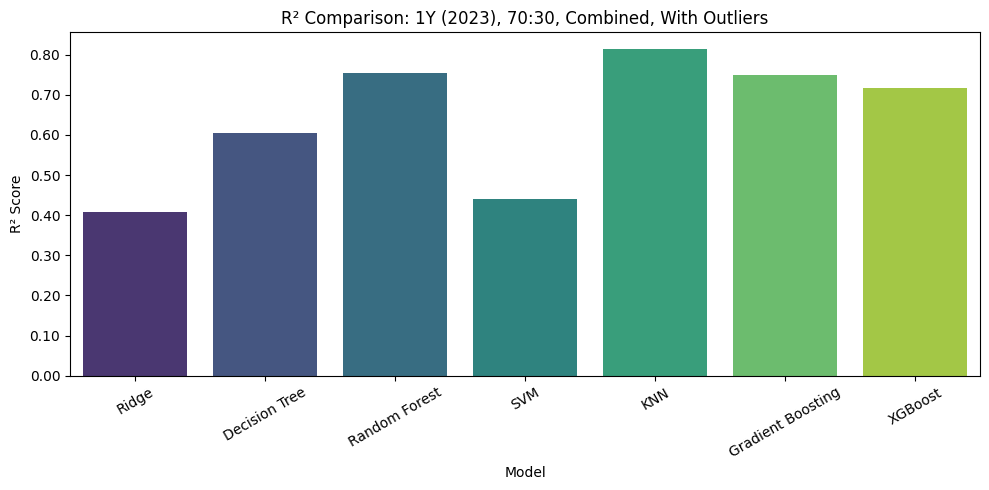

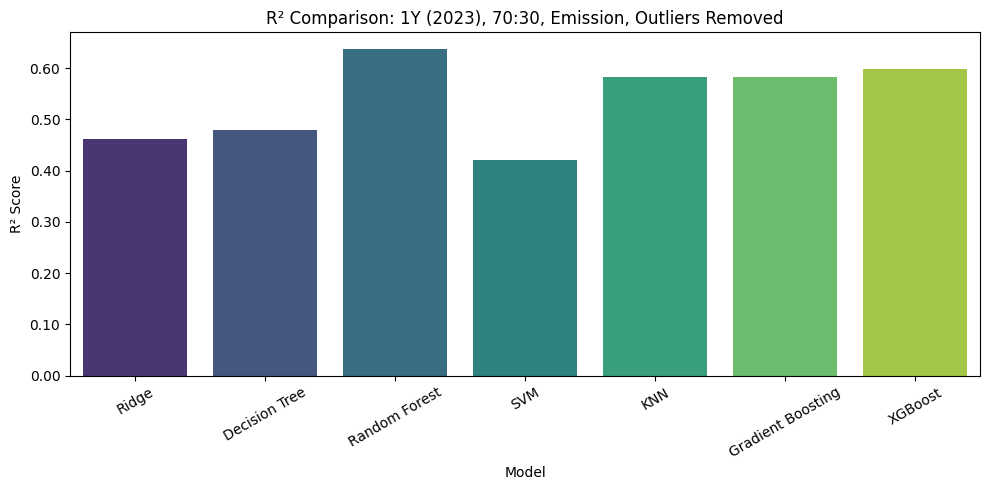

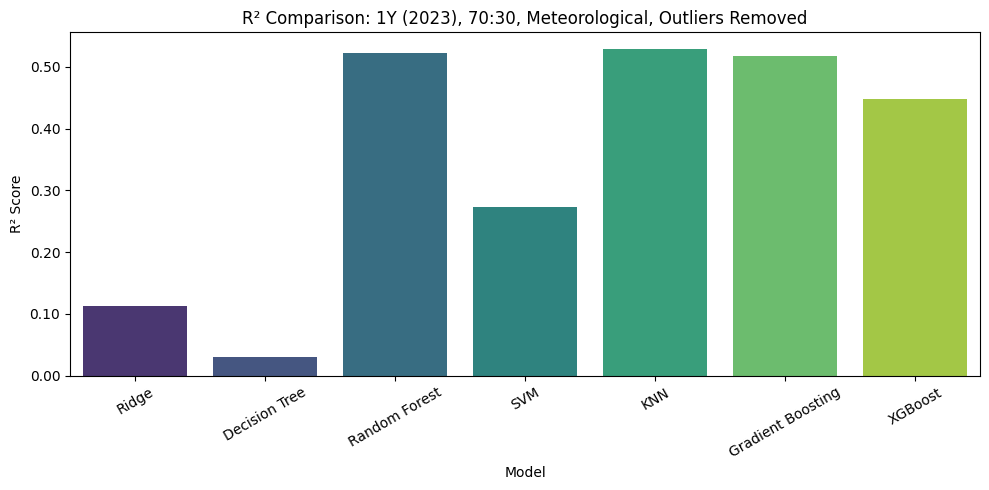

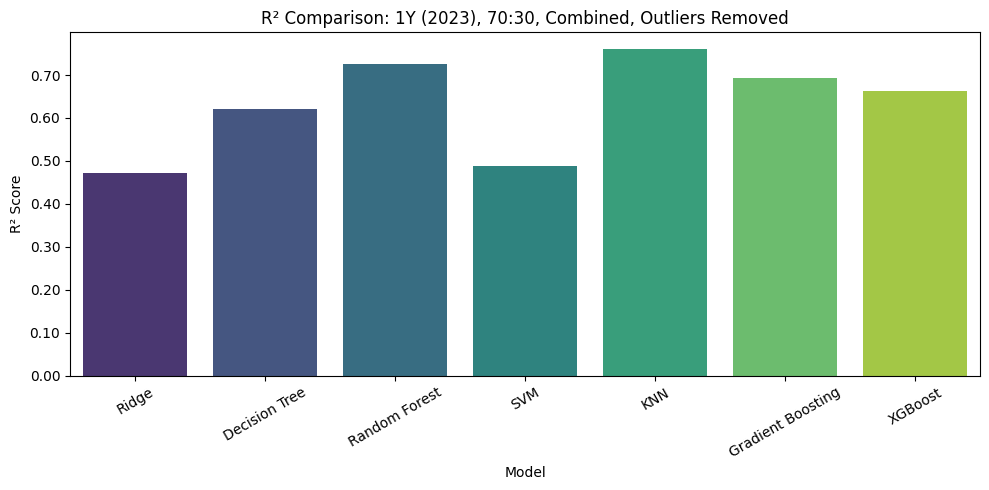

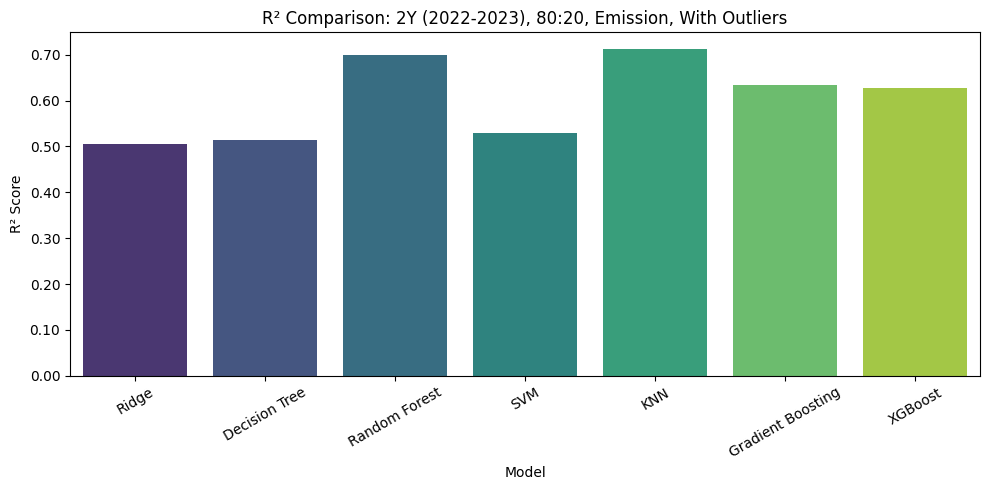

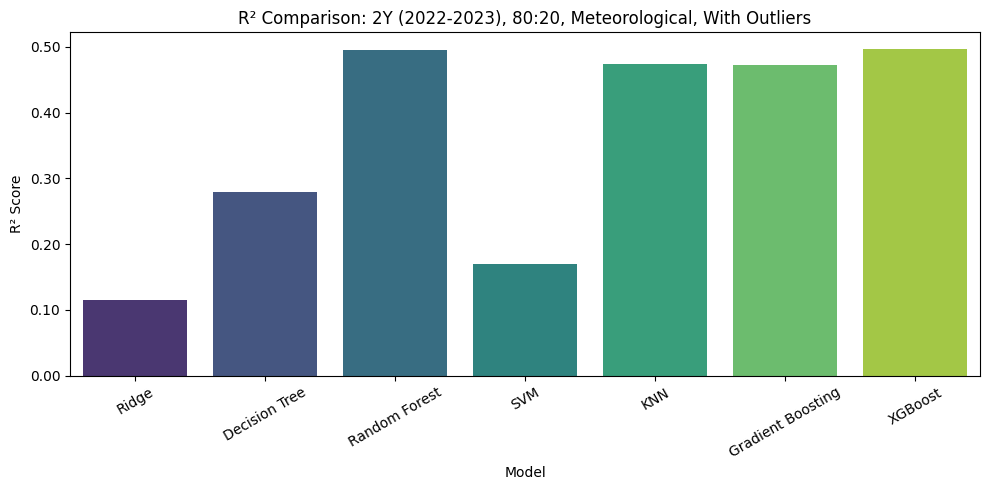

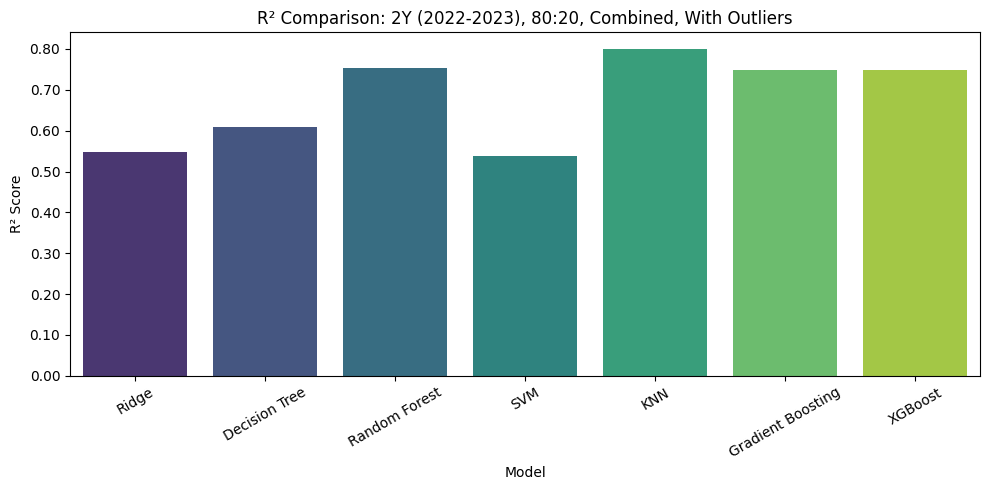

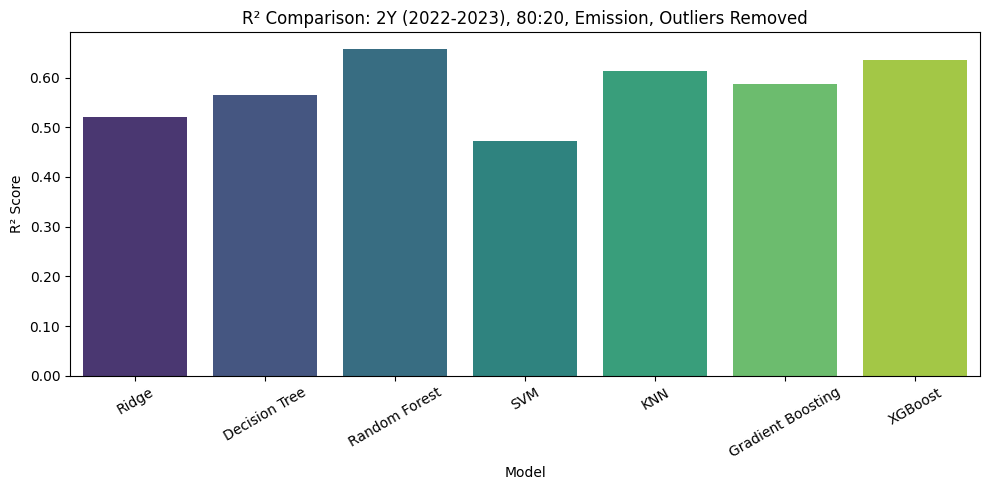

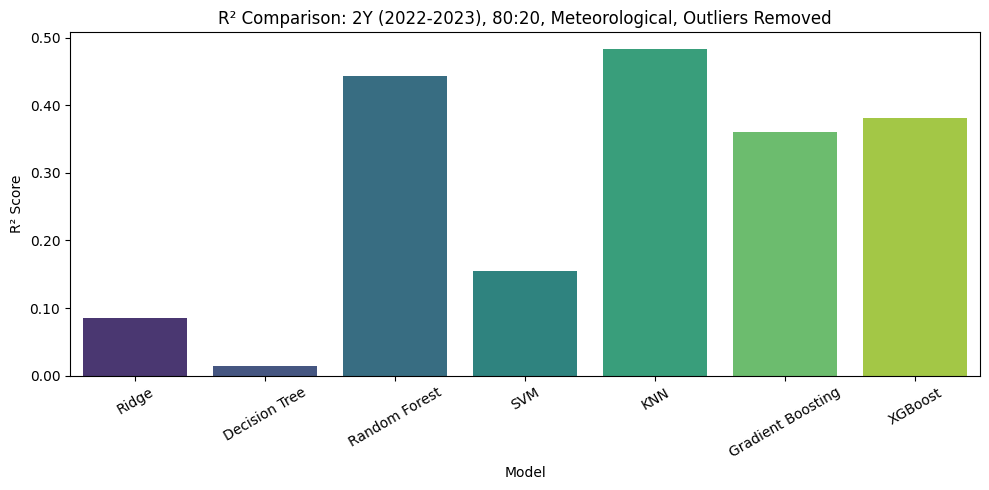

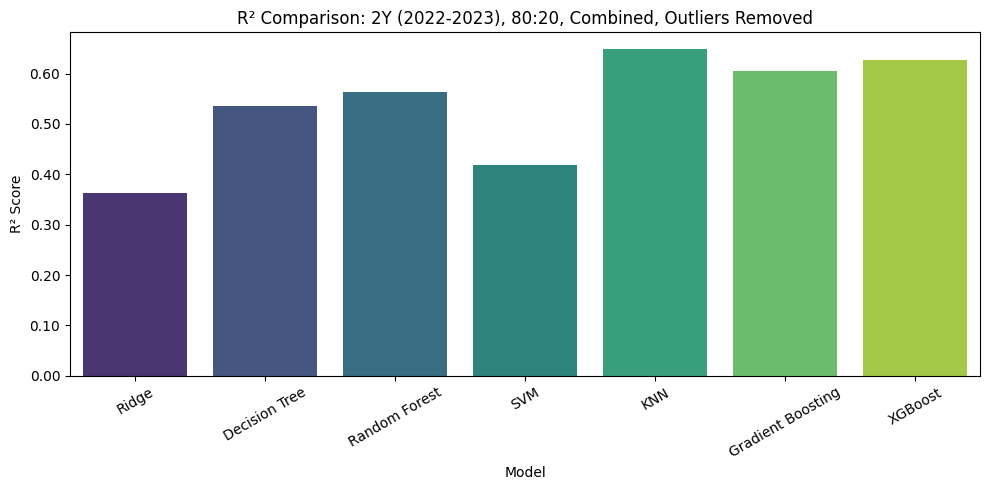

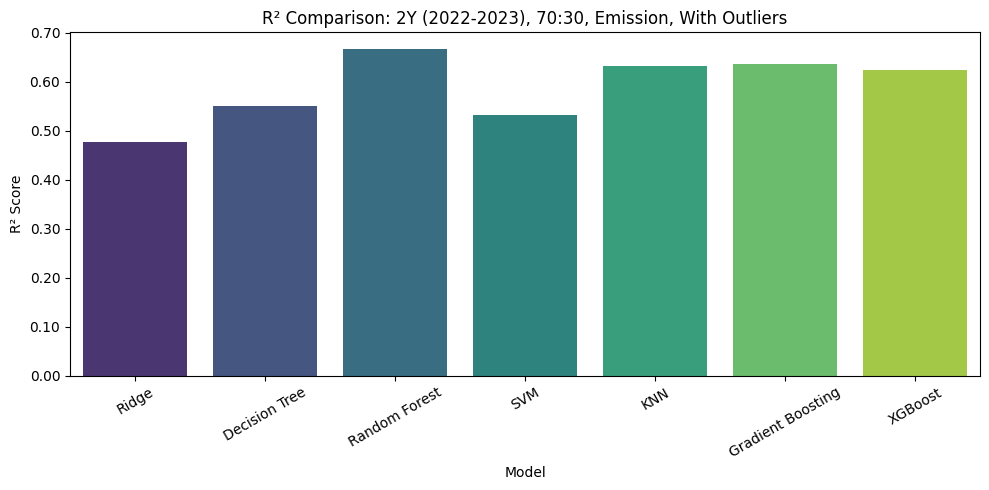

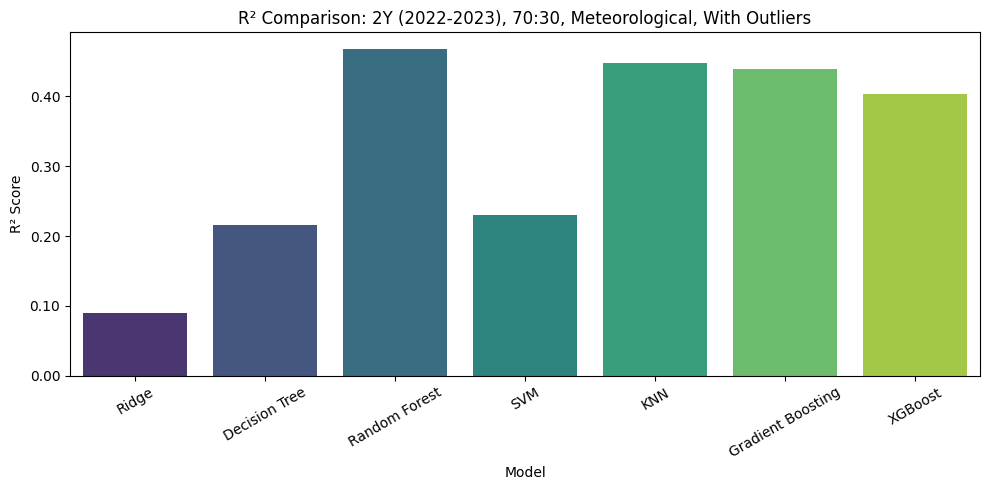

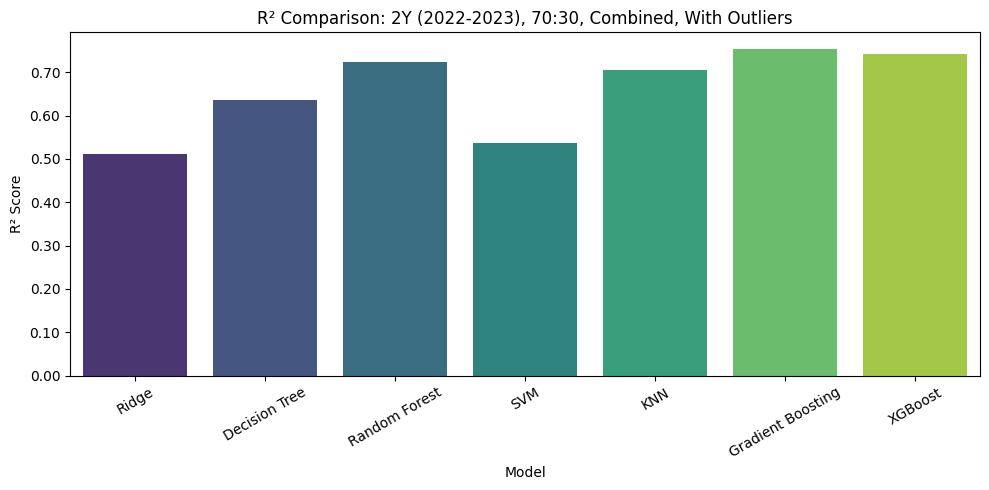

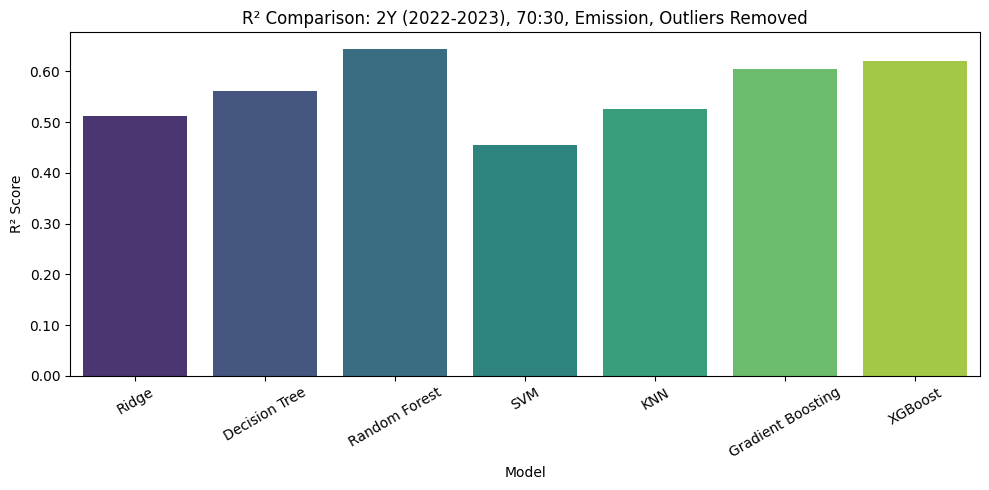

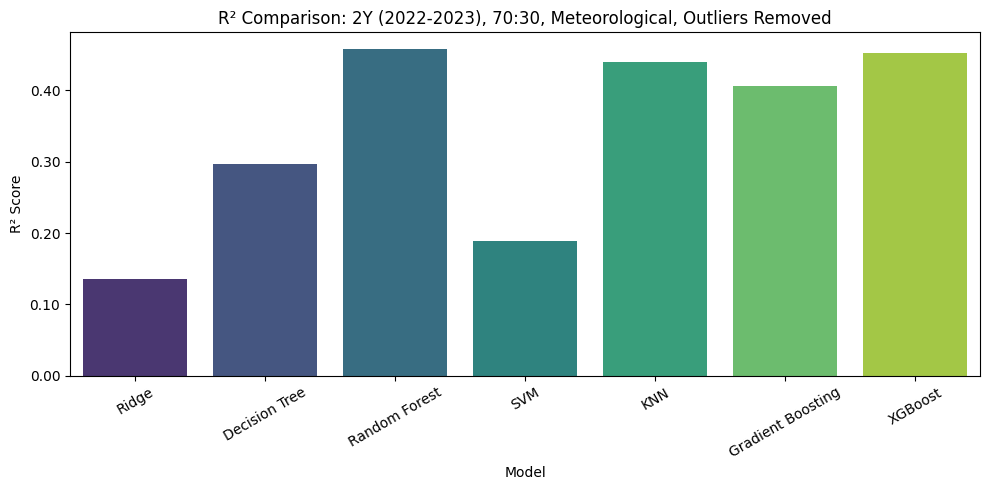

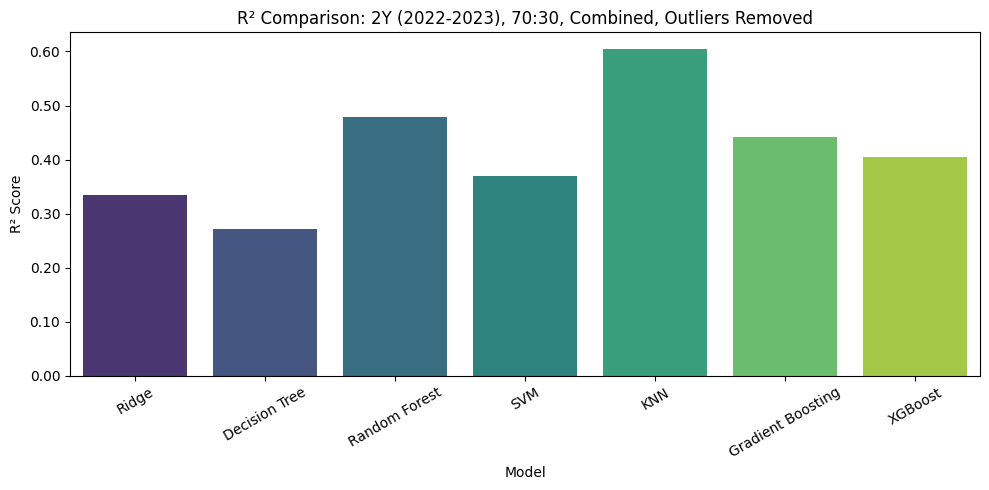

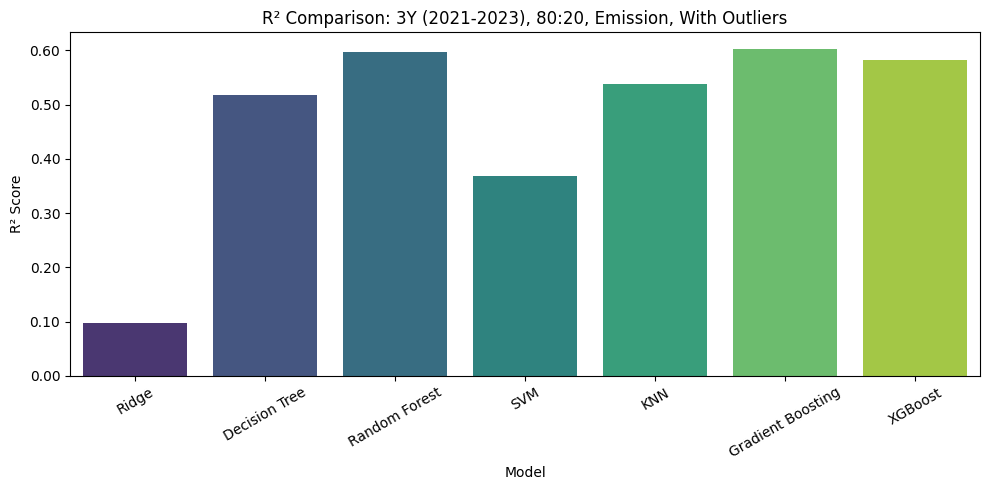

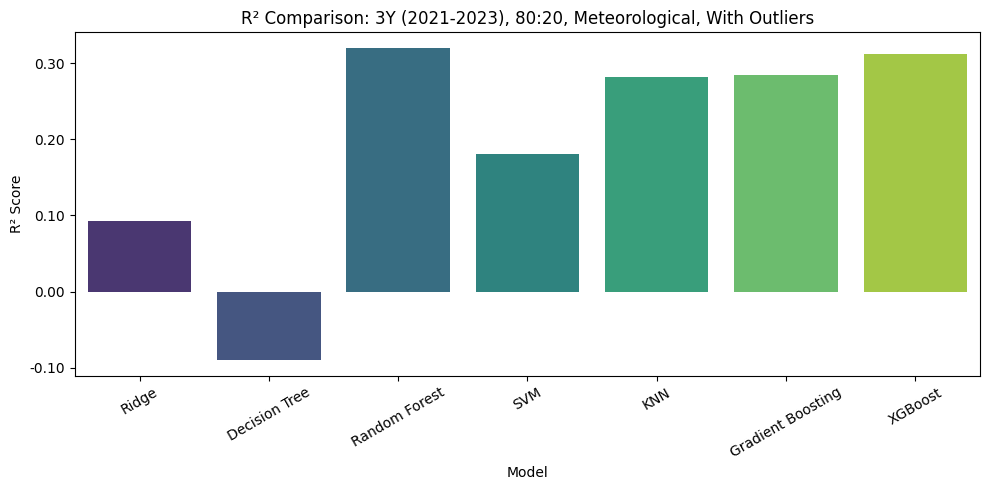

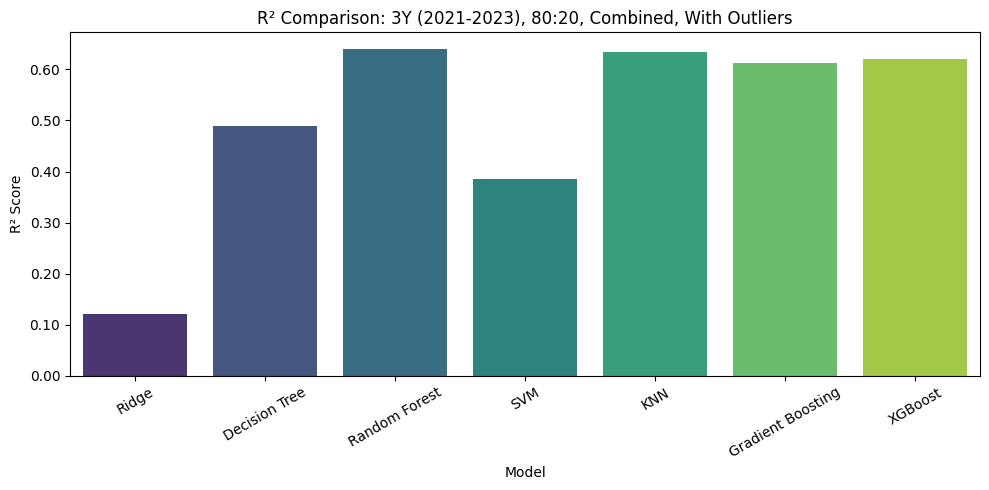

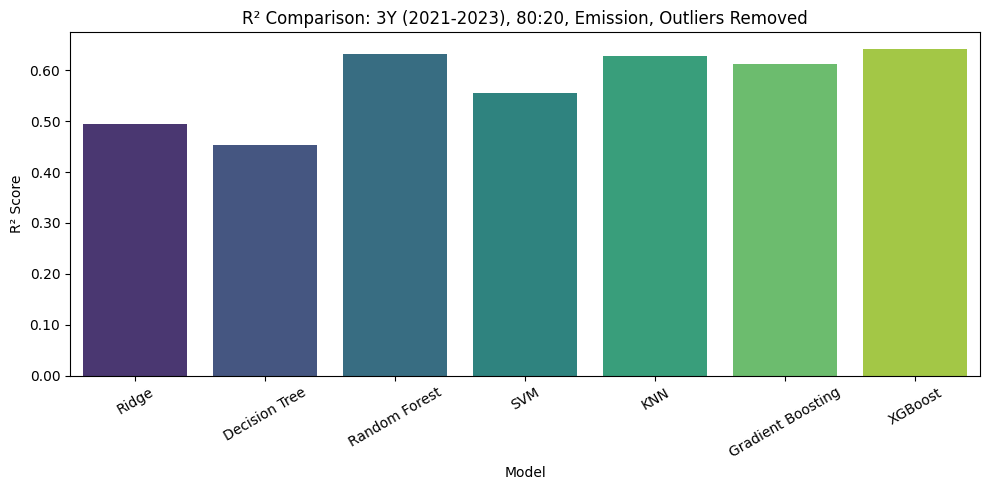

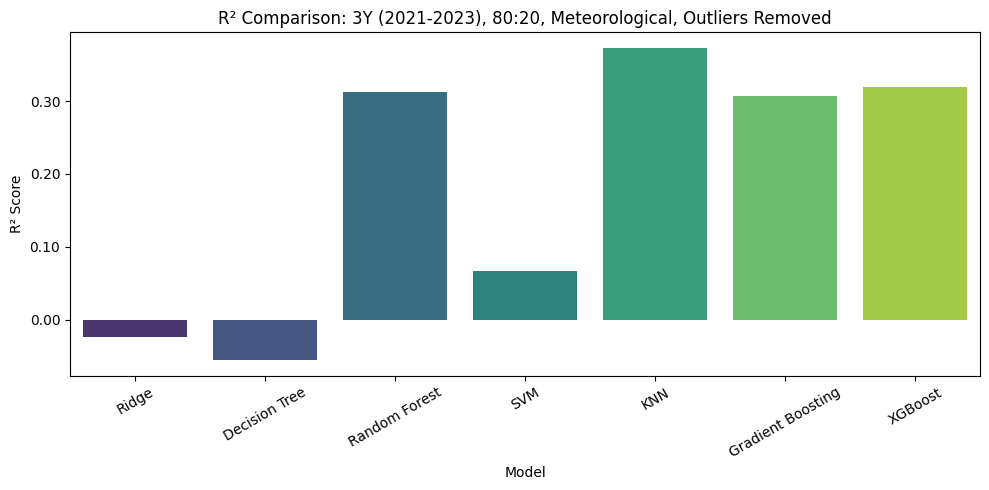

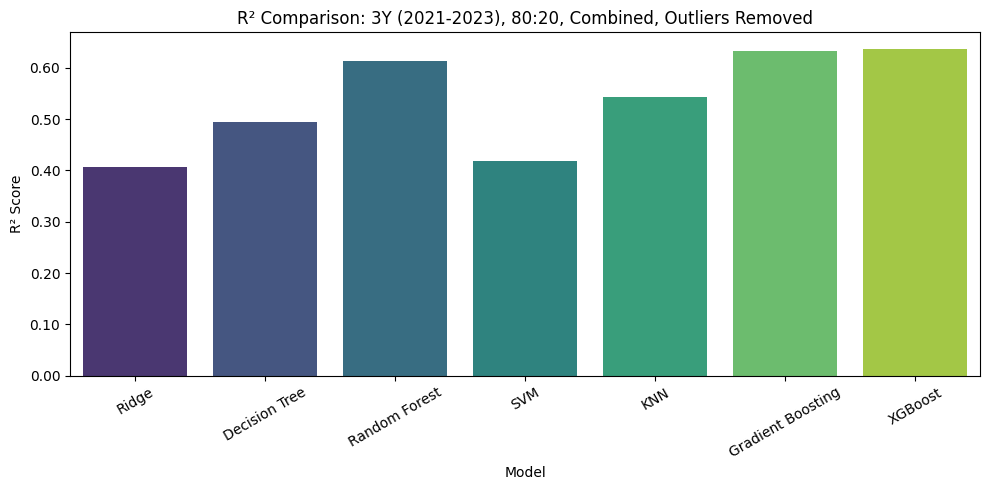

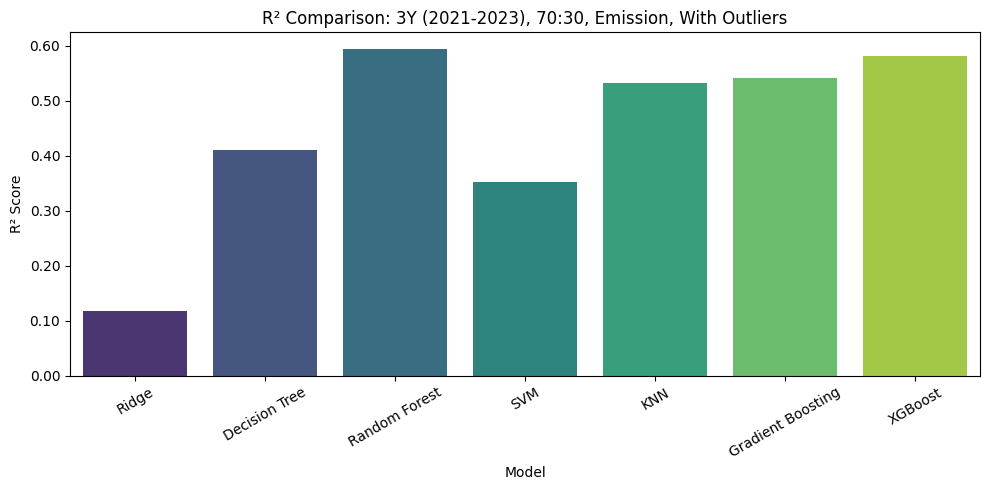

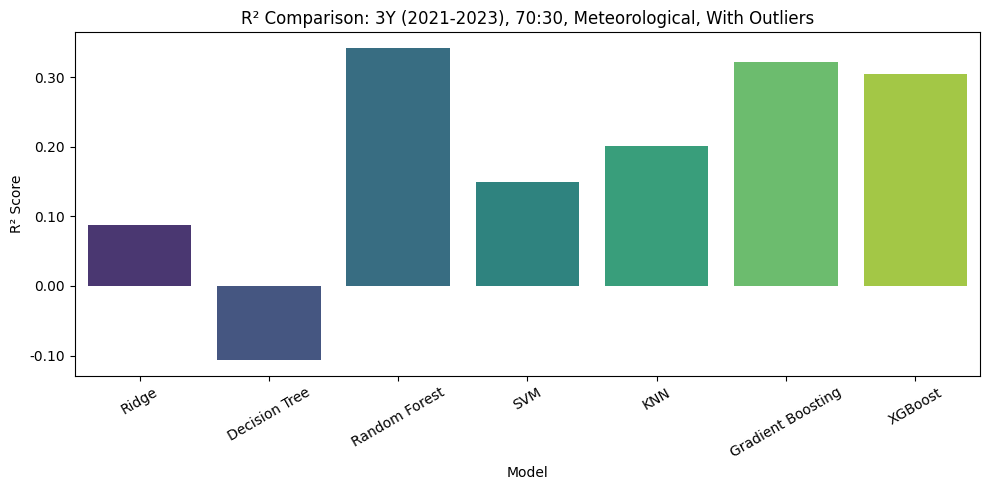

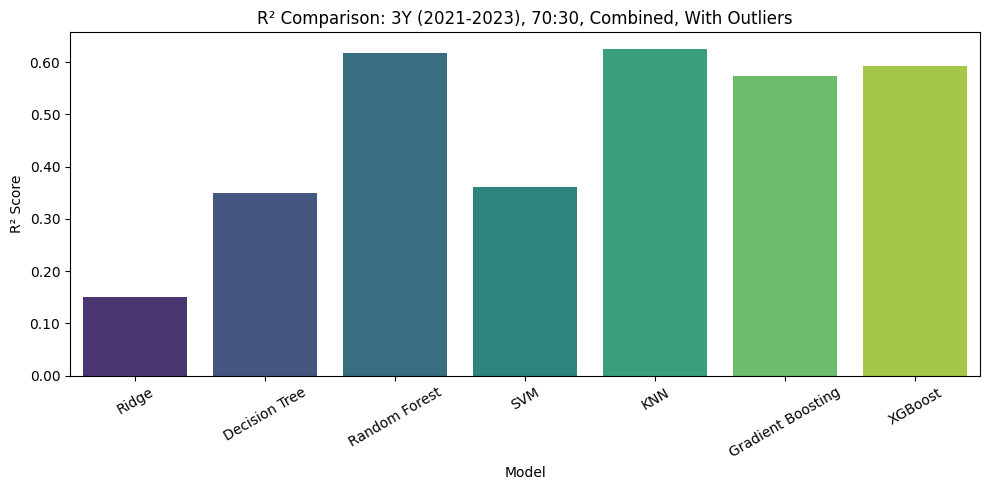

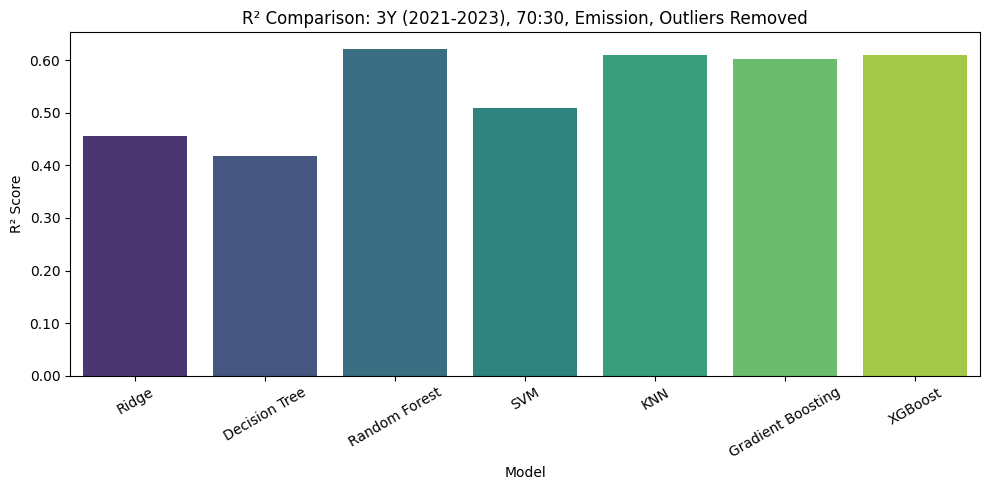

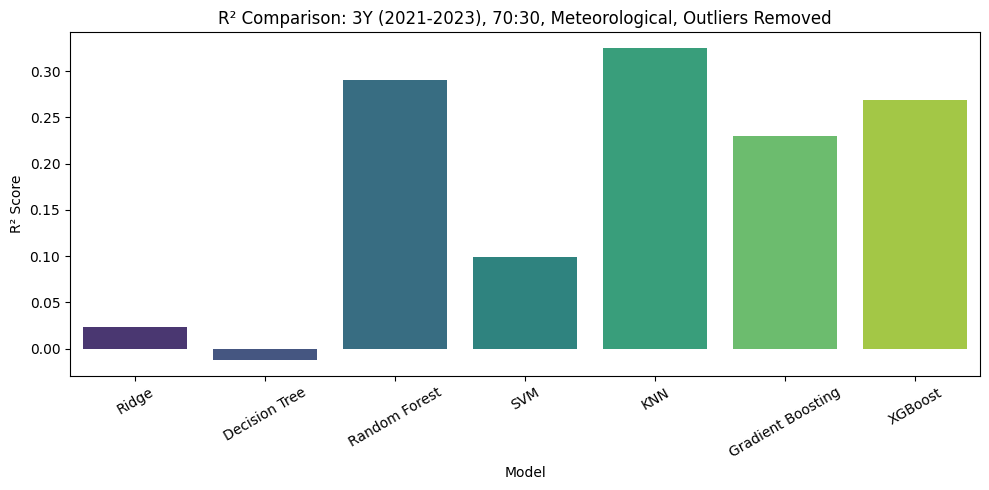

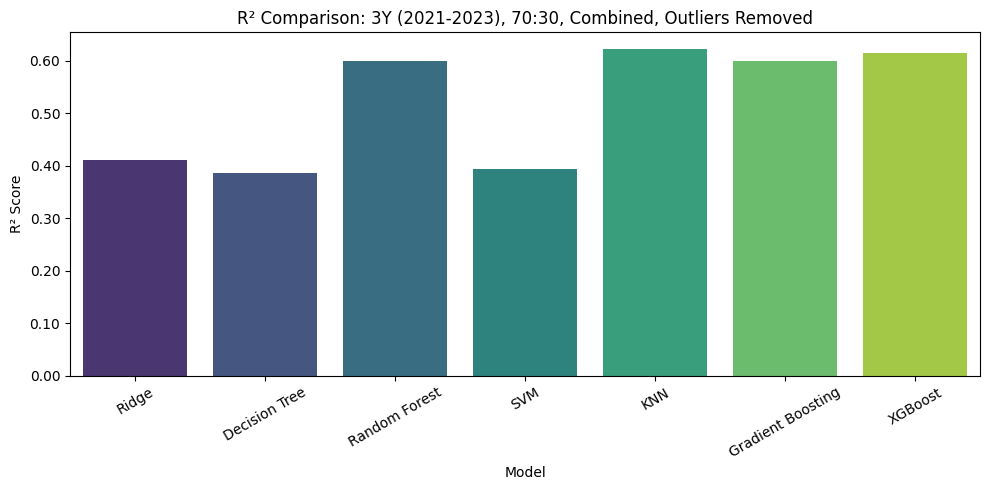

In [12]:
# -------------------------
# Plot Final Comparisons
# -------------------------
import matplotlib.ticker as mtick

for time_label in results_df['Time Window'].unique():
    print(f"Top 15 Results for: {time_label}")
    time_df = results_df[results_df['Time Window'] == time_label].sort_values(by='R2', ascending=False)
    display(time_df.head(15))

    for split_label in time_df['Split'].unique():
        for out_label in time_df['Outlier Handling'].unique():
            subset = time_df[(time_df['Split'] == split_label) &
                             (time_df['Outlier Handling'] == out_label)]
            for feat_label in time_df['Feature Set'].unique():
                data = subset[subset['Feature Set'] == feat_label]
                if data.empty:
                    continue
                data_melted = data.melt(id_vars=['Model'], value_vars=['R2', 'RMSE', 'MAE'], 
                                        var_name='Metric', value_name='Score')
                plt.figure(figsize=(12, 6))
                sns.barplot(data=data_melted, x='Model', y='Score', hue='Metric')
                plt.title(f"Metrics Comparison: {time_label}, {split_label}, {feat_label}, {out_label}")
                plt.ylabel("Score")
                plt.xticks(rotation=30)
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                plt.legend(loc='best')
                plt.tight_layout()
                plt.show()
import matplotlib.ticker as mtick

for time_label in results_df['Time Window'].unique():
    for split_label in results_df['Split'].unique():
        for out_label in results_df['Outlier Handling'].unique():
            subset = results_df[(results_df['Time Window'] == time_label) &
                                (results_df['Split'] == split_label) &
                                (results_df['Outlier Handling'] == out_label)]
            for feat_label in results_df['Feature Set'].unique():
                data = subset[subset['Feature Set'] == feat_label]
                plt.figure(figsize=(10, 5))
                sns.barplot(data=data, x='Model', y='R2', palette='viridis')
                plt.title(f"R² Comparison: {time_label}, {split_label}, {feat_label}, {out_label}")
                plt.ylabel("R² Score")
                plt.xticks(rotation=30)
                plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                plt.tight_layout()
                plt.show()

# -------------------------
# Optional: Save Results
# -------------------------
# results_df.to_csv("all_model_results.csv", index=False)
